In [342]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.layers import Dropout
import xgboost
import pickle

**Stock price prediction in 15 minutes for Microsoft, combining models and indicators.**

# DATA COLLECTION

In [343]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='D8JHWTNSXO7M9VKV', output_format='pandas')

In [344]:
data = ts.get_intraday(symbol='MSFT',interval='15min', outputsize='full')
data = data[0]
data.rename(lambda x: x[2:].strip(), axis='columns', inplace=True)
data

open    high       low   close  volume
date                                                           
2021-07-09 20:00:00  277.8000  277.94  277.8000  277.94  1600.0
2021-07-09 19:45:00  277.8000  277.80  277.7900  277.79  1233.0
2021-07-09 19:30:00  277.7900  277.80  277.7900  277.80  1053.0
2021-07-09 19:15:00  277.7800  277.78  277.7800  277.78   220.0
2021-07-09 19:00:00  277.7499  277.75  277.7499  277.75  1611.0
...                       ...     ...       ...     ...     ...
2021-06-01 05:45:00  251.3000  251.30  251.2900  251.29   598.0
2021-06-01 05:00:00  251.0000  251.35  251.0000  251.35   674.0
2021-06-01 04:45:00  250.9900  250.99  250.9900  250.99   297.0
2021-06-01 04:30:00  250.8300  250.83  250.8300  250.83   220.0
2021-06-01 04:15:00  250.9300  251.17  250.9300  251.17  2657.0

[1653 rows x 5 columns]

# INDICATORS CALCULATION

In [345]:
from alpha_vantage.techindicators import TechIndicators
ti = TechIndicators(key='D8JHWTNSXO7M9VKV', output_format='pandas')

## 1. Rate of Change (ROC)

In [346]:
indicator_roc = ti.get_roc(symbol='MSFT', interval='15min', time_period=20)
indicator_roc = indicator_roc[0]
indicator_roc

ROC
date                       
2021-06-01 10:15:00 -0.9117
2021-06-01 10:30:00 -0.8731
2021-06-01 10:45:00 -0.9164
2021-06-01 11:00:00 -1.3527
2021-06-01 11:15:00 -1.2615
...                     ...
2021-07-09 19:00:00  0.1406
2021-07-09 19:15:00  0.2563
2021-07-09 19:30:00  0.2345
2021-07-09 19:45:00  0.1984
2021-07-09 20:00:00  0.2019

[1633 rows x 1 columns]

## 2. Simple Moving Average (SMA)

In [347]:
indicator_sma = ti.get_sma(symbol='MSFT', interval='15min', time_period=20)
indicator_sma = indicator_sma[0]
indicator_sma

SMA
date                         
2021-06-01 10:00:00  250.7222
2021-06-01 10:15:00  250.6077
2021-06-01 10:30:00  250.4982
2021-06-01 10:45:00  250.3832
2021-06-01 11:00:00  250.2132
...                       ...
2021-07-09 19:00:00  277.6570
2021-07-09 19:15:00  277.6925
2021-07-09 19:30:00  277.7250
2021-07-09 19:45:00  277.7525
2021-07-09 20:00:00  277.7805

[1634 rows x 1 columns]

## 3. Relative Strength Index (RSI)

In [348]:
indicator_rsi = ti.get_rsi(symbol='MSFT', interval='15min', time_period=20)
indicator_rsi = indicator_rsi[0]
indicator_rsi

RSI
date                        
2021-06-01 10:15:00  31.2030
2021-06-01 10:30:00  29.9604
2021-06-01 10:45:00  30.5668
2021-06-01 11:00:00  26.9342
2021-06-01 11:15:00  28.9753
...                      ...
2021-07-09 19:00:00  53.8171
2021-07-09 19:15:00  54.1876
2021-07-09 19:30:00  54.4440
2021-07-09 19:45:00  54.2841
2021-07-09 20:00:00  56.3105

[1633 rows x 1 columns]

## 4. Bolling Bands (BBANDS)

In [349]:
indicator_bb = ti.get_bbands(symbol='MSFT', interval='15min', time_period=20)
indicator_bb = indicator_bb[0]
indicator_bb

Real Lower Band  Real Upper Band  Real Middle Band
date                                                                   
2021-07-09 20:00:00         277.3708         278.1902          277.7805
2021-07-09 19:45:00         277.3146         278.1904          277.7525
2021-07-09 19:30:00         277.2341         278.2159          277.7250
2021-07-09 19:15:00         277.1432         278.2418          277.6925
2021-07-09 19:00:00         277.0466         278.2674          277.6570
...                              ...              ...               ...
2021-06-01 11:00:00         248.3966         252.0298          250.2132
2021-06-01 10:45:00         248.8281         251.9383          250.3832
2021-06-01 10:30:00         249.1323         251.8641          250.4982
2021-06-01 10:15:00         249.5357         251.6797          250.6077
2021-06-01 10:00:00         249.9719         251.4725          250.7222

[1634 rows x 3 columns]

**Merge indicators to data**

In [350]:
original_df = pd.merge(data, indicator_roc, on='date', how='inner')
original_df = pd.merge(original_df, indicator_sma, on='date', how='inner')
original_df = pd.merge(original_df, indicator_rsi, on='date', how='inner')
original_df = pd.merge(original_df, indicator_bb, on='date', how='inner')
original_df = original_df.iloc[::-1]
original_df.to_csv('./DATA/MSFT.csv')
original_df

open    high       low   close     volume     ROC  \
date                                                                         
2021-06-01 10:15:00  250.0100  250.06  248.8700  248.88   815307.0 -0.9117   
2021-06-01 10:30:00  248.8700  248.87  247.9100  248.64  1142659.0 -0.8731   
2021-06-01 10:45:00  248.6500  249.13  248.5400  248.69   822538.0 -0.9164   
2021-06-01 11:00:00  248.6600  248.90  247.6800  247.95   850538.0 -1.3527   
2021-06-01 11:15:00  247.9400  250.50  247.6700  248.12  1663982.0 -1.2615   
...                       ...     ...       ...     ...        ...     ...   
2021-07-09 19:00:00  277.7499  277.75  277.7499  277.75     1611.0  0.1406   
2021-07-09 19:15:00  277.7800  277.78  277.7800  277.78      220.0  0.2563   
2021-07-09 19:30:00  277.7900  277.80  277.7900  277.80     1053.0  0.2345   
2021-07-09 19:45:00  277.8000  277.80  277.7900  277.79     1233.0  0.1984   
2021-07-09 20:00:00  277.8000  277.94  277.8000  277.94     1600.0  0.2019   

                          SMA      RSI  Real Lower Band  Real Upper Band  \
date                                                                       
2021-06-01 10:15:00  250.6077  31.2030         249.5357         251.6797   
2021-06-01 10:30:00  250.4982  29.9604         249.1323         251.8641   
2021-06-01 10:45:00  250.3832  30.5668         248.8281         251.9383   
2021-06-01 11:00:00  250.2132  26.9342         248.3966         252.0298   
2021-06-01 11:15:00  250.0547  28.9753         248.0941         252.0153   
...                       ...      ...              ...              ...   
2021-07-09 19:00:00  277.6570  53.8171         277.0466         278.2674   
2021-07-09 19:15:00  277.6925  54.1876         277.1432         278.2418   
2021-07-09 19:30:00  277.7250  54.4440         277.2341         278.2159   
2021-07-09 19:45:00  277.7525  54.2841         277.3146         278.1904   
2021-07-09 20:00:00  277.7805  56.3105         277.3708         278.1902   

                     Real Middle Band  
date                                   
2021-06-01 10:15:00          250.6077  
2021-06-01 10:30:00          250.4982  
2021-06-01 10:45:00          250.3832  
2021-06-01 11:00:00          250.2132  
2021-06-01 11:15:00          250.0547  
...                               ...  
2021-07-09 19:00:00          277.6570  
2021-07-09 19:15:00          277.6925  
2021-07-09 19:30:00          277.7250  
2021-07-09 19:45:00          277.7525  
2021-07-09 20:00:00          277.7805  

[1633 rows x 11 columns]

# MODEL TRAINING

## 1. LSTM

### a. Prepare Input

In [351]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[248.88],
       [248.64],
       [248.69],
       ...,
       [277.8 ],
       [277.79],
       [277.94]])

In [352]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.15385645],
       [0.14742903],
       [0.14876808],
       ...,
       [0.92836101],
       [0.9280932 ],
       [0.93211034]])

In [353]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1573
1573


In [354]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1259, 60, 1)
Size validate:  (157, 60, 1)
Size test:  (157, 60, 1)


### b. Train Model

In [355]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM.h5")

Epoch 1/20
40/40 [==============================] - 6s 70ms/step - loss: 0.0543 - val_loss: 0.0162
Epoch 2/20
40/40 [==============================] - 2s 50ms/step - loss: 0.0011 - val_loss: 6.1308e-04
Epoch 3/20
40/40 [==============================] - 2s 50ms/step - loss: 4.8300e-04 - val_loss: 0.0011
Epoch 4/20
40/40 [==============================] - 2s 57ms/step - loss: 4.7451e-04 - val_loss: 0.0013
Epoch 5/20
40/40 [==============================] - 2s 62ms/step - loss: 4.5263e-04 - val_loss: 9.5003e-04
Epoch 6/20
40/40 [==============================] - 2s 61ms/step - loss: 4.8785e-04 - val_loss: 8.3091e-04
Epoch 7/20
40/40 [==============================] - 2s 57ms/step - loss: 4.0678e-04 - val_loss: 6.6167e-04
Epoch 8/20
40/40 [==============================] - 3s 66ms/step - loss: 4.8000e-04 - val_loss: 0.0013
Epoch 9/20
40/40 [==============================] - 3s 66ms/step - loss: 4.4452e-04 - val_loss: 7.8194e-04
Epoch 10/20
40/40 [==============================] - 2s 57ms/

### c. Test Model

In [356]:
model_lstm = load_model('./MODEL/LSTM.h5')

In [357]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [358]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-358-665481fb171d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


date      open    high       low     close    volume  \
1476  2021-07-07 11:30:00  278.8400  278.97  278.5500  278.9300  624508.0   
1477  2021-07-07 11:45:00  278.9450  279.35  278.5200  279.3314  570070.0   
1478  2021-07-07 12:00:00  279.3200  279.98  279.3200  279.6900  510257.0   
1479  2021-07-07 12:15:00  279.7050  280.23  279.6600  280.0300  527682.0   
1480  2021-07-07 12:30:00  280.0500  280.24  279.7000  279.7200  661221.0   
...                   ...       ...     ...       ...       ...       ...   
1628  2021-07-09 19:00:00  277.7499  277.75  277.7499  277.7500    1611.0   
1629  2021-07-09 19:15:00  277.7800  277.78  277.7800  277.7800     220.0   
1630  2021-07-09 19:30:00  277.7900  277.80  277.7900  277.8000    1053.0   
1631  2021-07-09 19:45:00  277.8000  277.80  277.7900  277.7900    1233.0   
1632  2021-07-09 20:00:00  277.8000  277.94  277.8000  277.9400    1600.0   

         ROC       SMA      RSI  Real Lower Band  Real Upper Band  \
1476 -0.0681  279.1518  51.1594         278.4927         279.8108   
1477  0.1188  279.1683  54.7801         278.5087         279.8279   
1478  0.1576  279.1903  57.7271         278.4930         279.8876   
1479  0.3045  279.2328  60.3087         278.4454         280.0202   
1480  0.1575  279.2548  56.9696         278.4393         280.0703   
...      ...       ...      ...              ...              ...   
1628  0.1406  277.6570  53.8171         277.0466         278.2674   
1629  0.2563  277.6925  54.1876         277.1432         278.2418   
1630  0.2345  277.7250  54.4440         277.2341         278.2159   
1631  0.1984  277.7525  54.2841         277.3146         278.1904   
1632  0.2019  277.7805  56.3105         277.3708         278.1902   

      Real Middle Band  predictions  
1476          279.1518   278.777161  
1477          279.1683   278.746918  
1478          279.1903   278.733459  
1479          279.2328   278.750244  
1480          279.2548   278.803772  
...                ...          ...  
1628          277.6570   277.455109  
1629          277.6925   277.450256  
1630          277.7250   277.444458  
1631          277.7525   277.439453  
1632          277.7805   277.434631  

[157 rows x 13 columns]

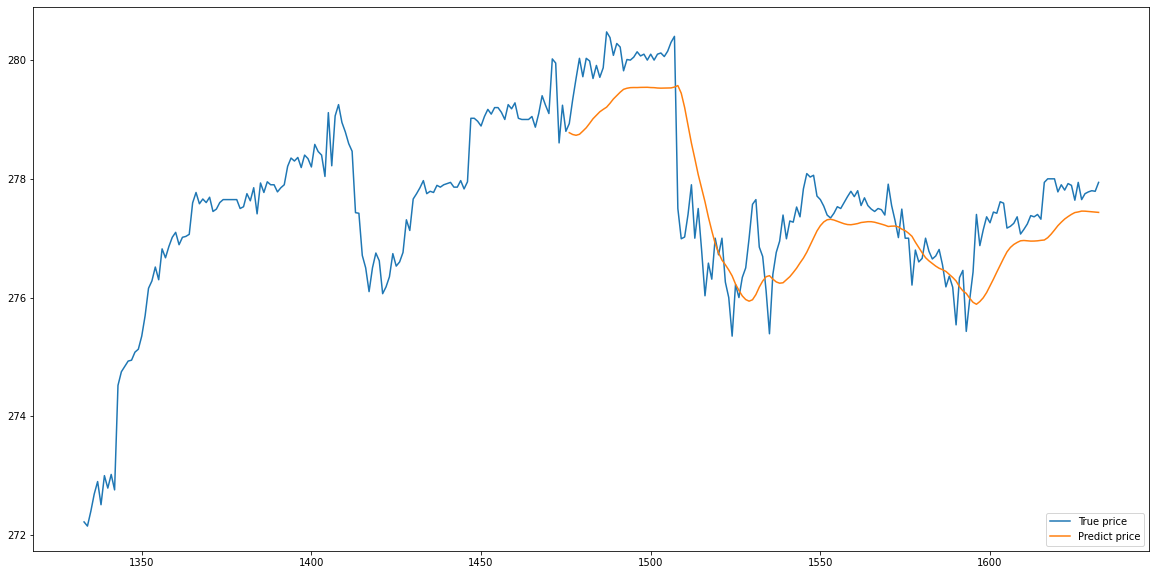

In [359]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [360]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 2.4888e+02, -9.1170e-01],
       [ 2.4864e+02, -8.7310e-01],
       [ 2.4869e+02, -9.1640e-01],
       ...,
       [ 2.7780e+02,  2.3450e-01],
       [ 2.7779e+02,  1.9840e-01],
       [ 2.7794e+02,  2.0190e-01]])

In [361]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.15385645, 0.21469751],
       [0.14742903, 0.22363455],
       [0.14876808, 0.21360932],
       ...,
       [0.92836101, 0.48007687],
       [0.9280932 , 0.47171865],
       [0.93211034, 0.472529  ]])

In [362]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1573
1573


In [363]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1259, 60, 2)
Size validate:  (157, 60, 2)
Size test:  (157, 60, 2)


In [364]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC.h5")

Epoch 1/20
40/40 [==============================] - 8s 77ms/step - loss: 0.0496 - val_loss: 0.0025
Epoch 2/20
40/40 [==============================] - 2s 56ms/step - loss: 7.5815e-04 - val_loss: 3.8620e-04
Epoch 3/20
40/40 [==============================] - 3s 64ms/step - loss: 3.9078e-04 - val_loss: 4.3522e-04
Epoch 4/20
40/40 [==============================] - 2s 60ms/step - loss: 3.6070e-04 - val_loss: 2.8823e-04
Epoch 5/20
40/40 [==============================] - 2s 62ms/step - loss: 3.1637e-04 - val_loss: 3.8661e-04
Epoch 6/20
40/40 [==============================] - 3s 65ms/step - loss: 2.9489e-04 - val_loss: 2.5982e-04
Epoch 7/20
40/40 [==============================] - 3s 65ms/step - loss: 2.8548e-04 - val_loss: 3.3669e-04
Epoch 8/20
40/40 [==============================] - 3s 68ms/step - loss: 3.1723e-04 - val_loss: 3.9686e-04
Epoch 9/20
40/40 [==============================] - 2s 58ms/step - loss: 2.8240e-04 - val_loss: 2.8640e-04
Epoch 10/20
40/40 [==========================

In [365]:
model_lstm = load_model('./MODEL/LSTM_ROC.h5')

In [366]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]
predictions

array([279.08167, 279.02792, 279.04886, 279.11667, 279.24924, 279.3425 ,
       279.4788 , 279.60495, 279.67398, 279.74097, 279.76532, 279.80838,
       279.9051 , 279.97324, 280.00845, 280.0673 , 280.0362 , 279.94962,
       280.00433, 280.02597, 280.08755, 280.1472 , 280.153  , 280.11557,
       280.03052, 279.989  , 279.92844, 279.89578, 279.91043, 279.91287,
       279.9457 , 279.9883 , 279.99097, 279.62546, 279.13535, 278.62537,
       278.2174 , 277.9936 , 277.72476, 277.542  , 277.30984, 276.9764 ,
       276.71747, 276.46832, 276.34988, 276.24283, 276.20044, 276.0765 ,
       275.90027, 275.6388 , 275.47565, 275.32013, 275.22513, 275.45444,
       275.84927, 276.3053 , 276.683  , 276.82263, 276.91165, 276.82184,
       276.63962, 276.62546, 276.6467 , 276.72946, 276.81238, 276.8673 ,
       276.91855, 277.031  , 277.2001 , 277.40012, 277.55453, 277.73193,
       277.85318, 277.9353 , 277.90836, 277.80008, 277.67053, 277.6146 ,
       277.5984 , 277.66266, 277.819  , 277.87805, 

In [367]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-367-665481fb171d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


date      open    high       low     close    volume  \
1476  2021-07-07 11:30:00  278.8400  278.97  278.5500  278.9300  624508.0   
1477  2021-07-07 11:45:00  278.9450  279.35  278.5200  279.3314  570070.0   
1478  2021-07-07 12:00:00  279.3200  279.98  279.3200  279.6900  510257.0   
1479  2021-07-07 12:15:00  279.7050  280.23  279.6600  280.0300  527682.0   
1480  2021-07-07 12:30:00  280.0500  280.24  279.7000  279.7200  661221.0   
...                   ...       ...     ...       ...       ...       ...   
1628  2021-07-09 19:00:00  277.7499  277.75  277.7499  277.7500    1611.0   
1629  2021-07-09 19:15:00  277.7800  277.78  277.7800  277.7800     220.0   
1630  2021-07-09 19:30:00  277.7900  277.80  277.7900  277.8000    1053.0   
1631  2021-07-09 19:45:00  277.8000  277.80  277.7900  277.7900    1233.0   
1632  2021-07-09 20:00:00  277.8000  277.94  277.8000  277.9400    1600.0   

         ROC       SMA      RSI  Real Lower Band  Real Upper Band  \
1476 -0.0681  279.1518  51.1594         278.4927         279.8108   
1477  0.1188  279.1683  54.7801         278.5087         279.8279   
1478  0.1576  279.1903  57.7271         278.4930         279.8876   
1479  0.3045  279.2328  60.3087         278.4454         280.0202   
1480  0.1575  279.2548  56.9696         278.4393         280.0703   
...      ...       ...      ...              ...              ...   
1628  0.1406  277.6570  53.8171         277.0466         278.2674   
1629  0.2563  277.6925  54.1876         277.1432         278.2418   
1630  0.2345  277.7250  54.4440         277.2341         278.2159   
1631  0.1984  277.7525  54.2841         277.3146         278.1904   
1632  0.2019  277.7805  56.3105         277.3708         278.1902   

      Real Middle Band  predictions  
1476          279.1518   279.081665  
1477          279.1683   279.027924  
1478          279.1903   279.048859  
1479          279.2328   279.116669  
1480          279.2548   279.249237  
...                ...          ...  
1628          277.6570   277.880188  
1629          277.6925   277.889099  
1630          277.7250   277.921692  
1631          277.7525   277.948761  
1632          277.7805   277.960297  

[157 rows x 13 columns]

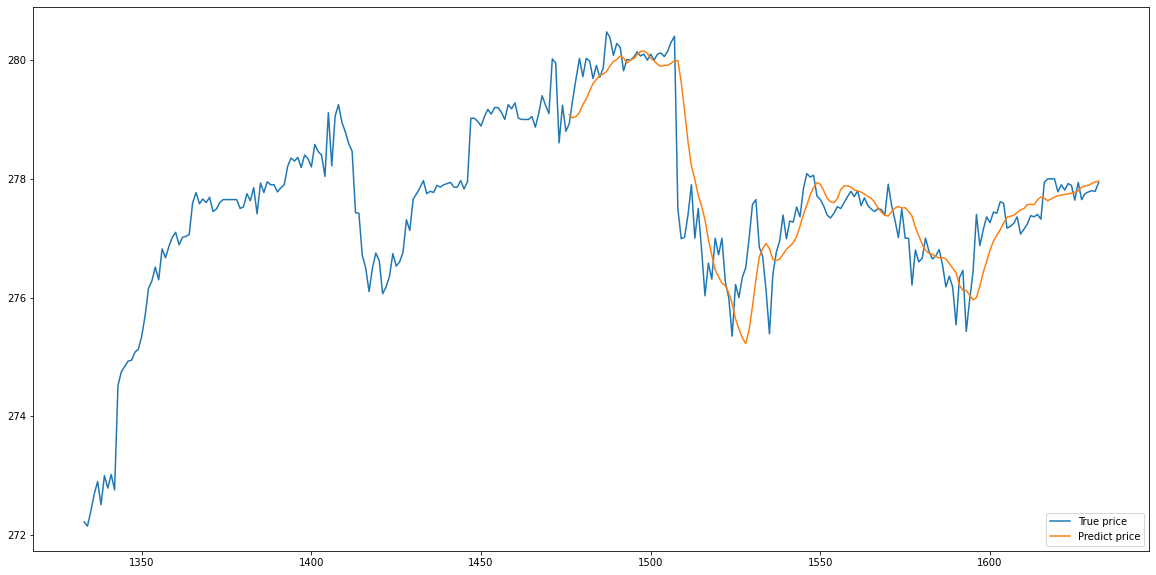

In [368]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/20
40/40 [==============================] - 7s 68ms/step - loss: 0.0721 - val_loss: 0.0211
Epoch 2/20
40/40 [==============================] - 2s 49ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 3/20
40/40 [==============================] - 2s 55ms/step - loss: 6.3954e-04 - val_loss: 8.9288e-04
Epoch 4/20
40/40 [==============================] - 2s 63ms/step - loss: 5.2367e-04 - val_loss: 0.0015
Epoch 5/20
40/40 [==============================] - 3s 65ms/step - loss: 5.4361e-04 - val_loss: 0.0012
Epoch 6/20
40/40 [==============================] - 3s 71ms/step - loss: 5.0949e-04 - val_loss: 9.2316e-04
Epoch 7/20
40/40 [==============================] - 3s 68ms/step - loss: 4.8230e-04 - val_loss: 9.5822e-04
Epoch 8/20
40/40 [==============================] - 2s 58ms/step - loss: 4.1736e-04 - val_loss: 6.9286e-04
Epoch 9/20
40/40 [==============================] - 2s 58ms/step - loss: 4.3198e-04 - val_loss: 5.5224e-04
Epoch 10/20
40/40 [==============================] - 3s 65ms/

<ipython-input-369-af23f6c3d72a>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


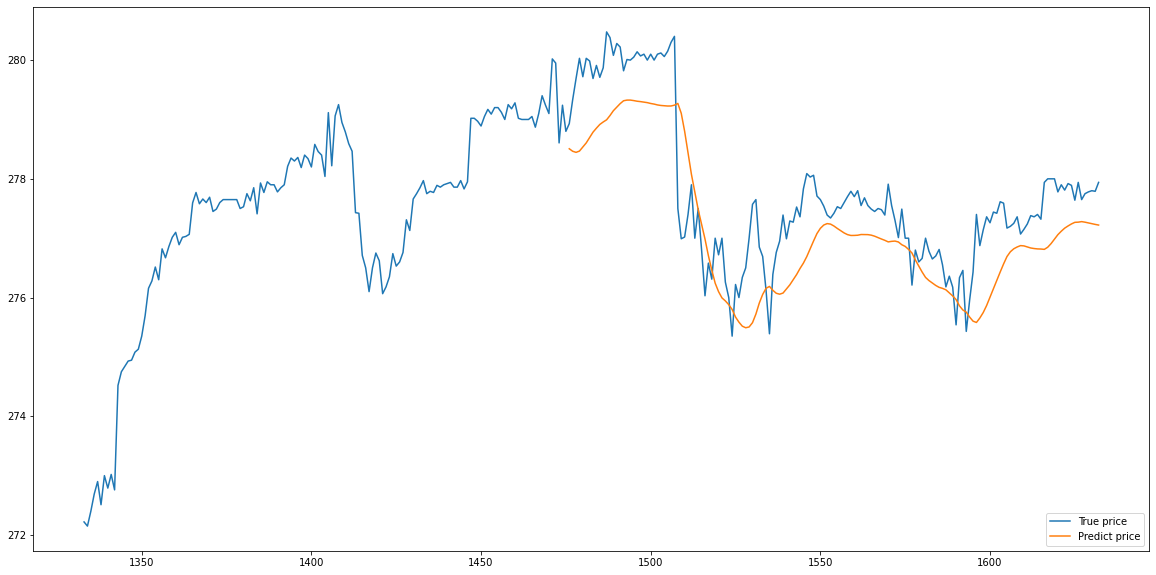

In [369]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/20
40/40 [==============================] - 8s 80ms/step - loss: 0.0407 - val_loss: 0.0022
Epoch 2/20
40/40 [==============================] - 2s 52ms/step - loss: 8.7801e-04 - val_loss: 0.0024
Epoch 3/20
40/40 [==============================] - 2s 53ms/step - loss: 3.7734e-04 - val_loss: 5.5050e-04
Epoch 4/20
40/40 [==============================] - 2s 57ms/step - loss: 3.5398e-04 - val_loss: 5.4951e-04
Epoch 5/20
40/40 [==============================] - 2s 58ms/step - loss: 3.1638e-04 - val_loss: 6.5088e-04
Epoch 6/20
40/40 [==============================] - 3s 63ms/step - loss: 3.2022e-04 - val_loss: 5.6115e-04
Epoch 7/20
40/40 [==============================] - 2s 59ms/step - loss: 2.7365e-04 - val_loss: 3.5475e-04
Epoch 8/20
40/40 [==============================] - 3s 67ms/step - loss: 2.6360e-04 - val_loss: 3.1376e-04
Epoch 9/20
40/40 [==============================] - 2s 59ms/step - loss: 2.7042e-04 - val_loss: 3.7884e-04
Epoch 10/20
40/40 [==============================

<ipython-input-370-75b2841e25f8>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


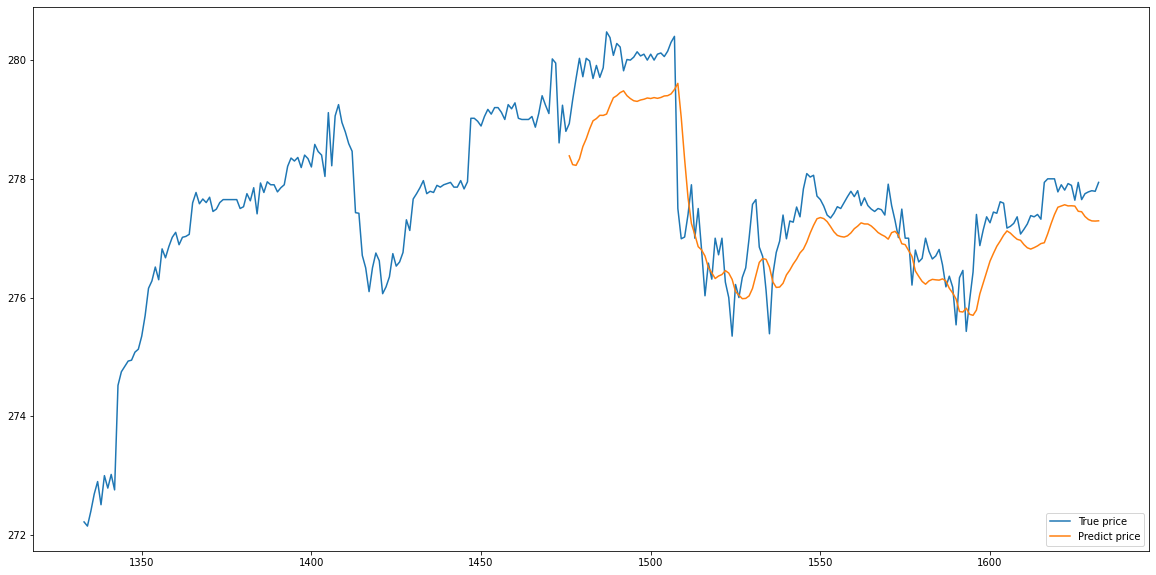

In [370]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/20
40/40 [==============================] - 6s 78ms/step - loss: 0.0319 - val_loss: 0.0067
Epoch 2/20
40/40 [==============================] - 2s 54ms/step - loss: 9.9479e-04 - val_loss: 0.0027
Epoch 3/20
40/40 [==============================] - 2s 54ms/step - loss: 6.2549e-04 - val_loss: 0.0022
Epoch 4/20
40/40 [==============================] - 2s 54ms/step - loss: 6.3333e-04 - val_loss: 0.0016
Epoch 5/20
40/40 [==============================] - 2s 60ms/step - loss: 5.8246e-04 - val_loss: 0.0016
Epoch 6/20
40/40 [==============================] - 3s 63ms/step - loss: 5.6571e-04 - val_loss: 8.9705e-04
Epoch 7/20
40/40 [==============================] - 2s 57ms/step - loss: 5.4217e-04 - val_loss: 0.0012
Epoch 8/20
40/40 [==============================] - 2s 61ms/step - loss: 5.1415e-04 - val_loss: 6.8784e-04
Epoch 9/20
40/40 [==============================] - 2s 60ms/step - loss: 4.7820e-04 - val_loss: 4.1348e-04
Epoch 10/20
40/40 [==============================] - 2s 59ms/step

<ipython-input-373-115a62558a9e>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


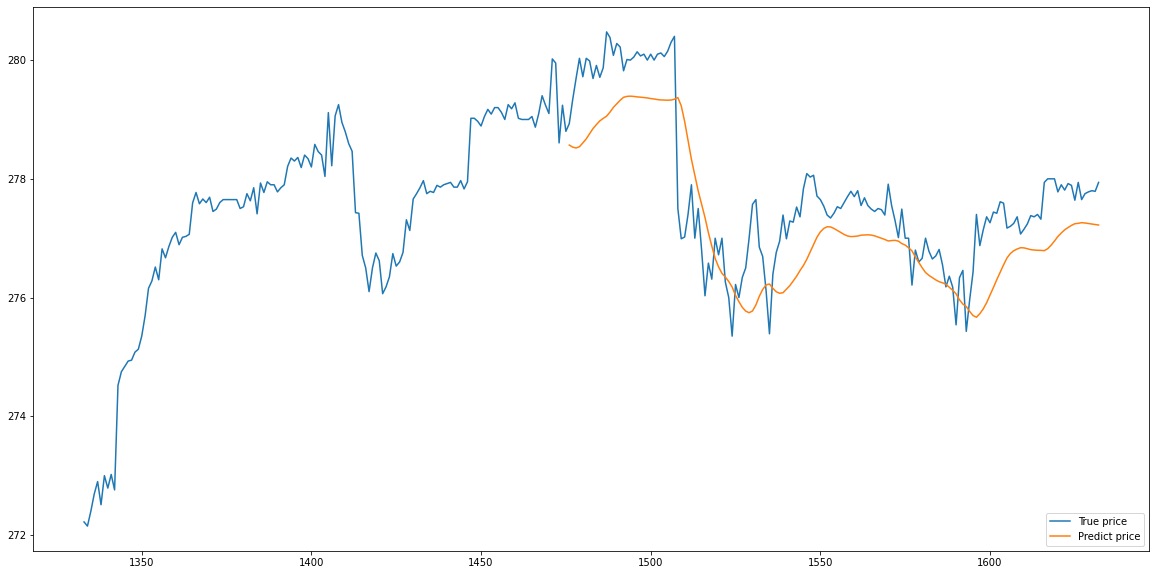

In [373]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/20
40/40 [==============================] - 6s 68ms/step - loss: 0.0860 - val_loss: 0.0225
Epoch 2/20
40/40 [==============================] - 2s 50ms/step - loss: 0.0016 - val_loss: 0.0049
Epoch 3/20
40/40 [==============================] - 2s 57ms/step - loss: 7.8951e-04 - val_loss: 0.0029
Epoch 4/20
40/40 [==============================] - 2s 63ms/step - loss: 5.7560e-04 - val_loss: 0.0018
Epoch 5/20
40/40 [==============================] - 3s 63ms/step - loss: 4.8312e-04 - val_loss: 0.0011
Epoch 6/20
40/40 [==============================] - 2s 60ms/step - loss: 4.0015e-04 - val_loss: 0.0011
Epoch 7/20
40/40 [==============================] - 2s 59ms/step - loss: 4.0041e-04 - val_loss: 0.0013
Epoch 8/20
40/40 [==============================] - 2s 57ms/step - loss: 3.6306e-04 - val_loss: 5.8463e-04
Epoch 9/20
40/40 [==============================] - 2s 60ms/step - loss: 3.7524e-04 - val_loss: 0.0013
Epoch 10/20
40/40 [==============================] - 2s 59ms/step - loss: 3.8

<ipython-input-374-fb1aa65bd9ea>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


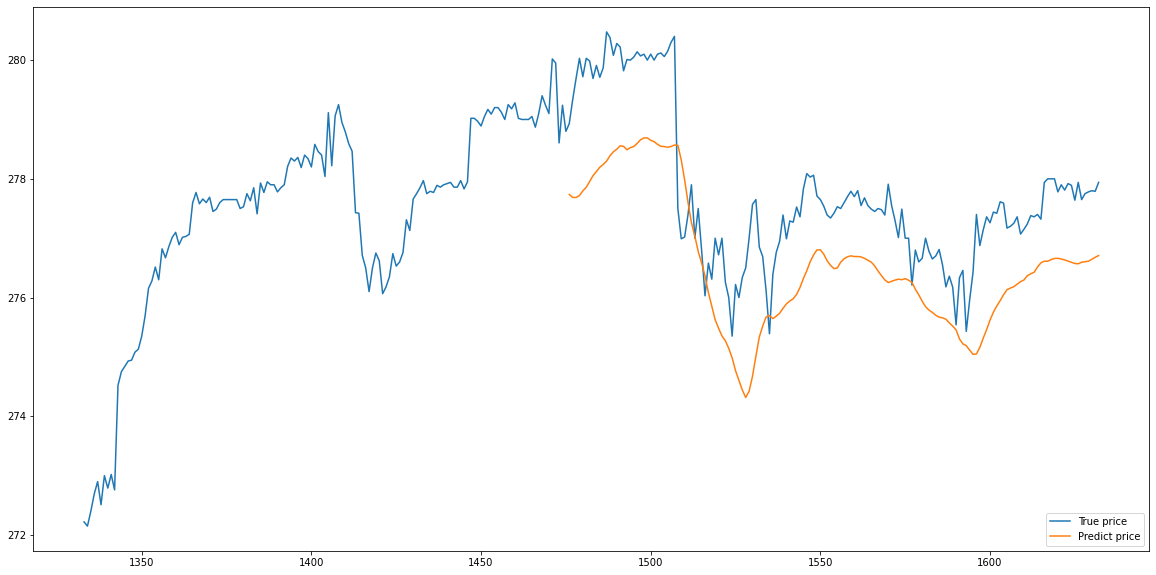

In [374]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/20
40/40 [==============================] - 6s 74ms/step - loss: 0.0407 - val_loss: 0.0036
Epoch 2/20
40/40 [==============================] - 2s 50ms/step - loss: 9.7473e-04 - val_loss: 0.0026
Epoch 3/20
40/40 [==============================] - 2s 53ms/step - loss: 4.8131e-04 - val_loss: 0.0017
Epoch 4/20
40/40 [==============================] - 3s 65ms/step - loss: 3.5810e-04 - val_loss: 9.7731e-04
Epoch 5/20
40/40 [==============================] - 2s 59ms/step - loss: 2.9984e-04 - val_loss: 0.0012
Epoch 6/20
40/40 [==============================] - 2s 57ms/step - loss: 2.8050e-04 - val_loss: 9.5441e-04
Epoch 7/20
40/40 [==============================] - 2s 58ms/step - loss: 2.7414e-04 - val_loss: 5.7203e-04
Epoch 8/20
40/40 [==============================] - 2s 59ms/step - loss: 2.9113e-04 - val_loss: 6.8326e-04
Epoch 9/20
40/40 [==============================] - 2s 59ms/step - loss: 2.7193e-04 - val_loss: 9.1413e-04
Epoch 10/20
40/40 [==============================] - 2s 5

<ipython-input-375-bfb6914a0740>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


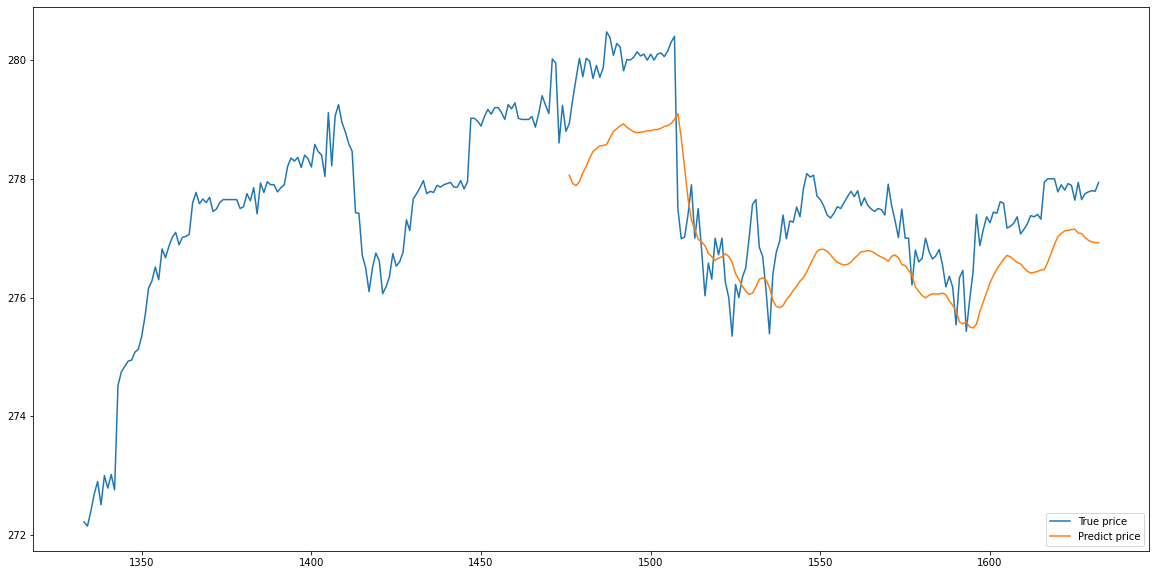

In [375]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/20
40/40 [==============================] - 7s 77ms/step - loss: 0.0773 - val_loss: 0.0213
Epoch 2/20
40/40 [==============================] - 2s 55ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 3/20
40/40 [==============================] - 3s 68ms/step - loss: 8.3178e-04 - val_loss: 0.0042
Epoch 4/20
40/40 [==============================] - 3s 72ms/step - loss: 8.0314e-04 - val_loss: 0.0036
Epoch 5/20
40/40 [==============================] - 2s 58ms/step - loss: 7.7811e-04 - val_loss: 0.0019
Epoch 6/20
40/40 [==============================] - 2s 51ms/step - loss: 7.3821e-04 - val_loss: 0.0017
Epoch 7/20
40/40 [==============================] - 2s 61ms/step - loss: 6.3144e-04 - val_loss: 9.7748e-04
Epoch 8/20
40/40 [==============================] - 2s 53ms/step - loss: 5.7182e-04 - val_loss: 0.0013
Epoch 9/20
40/40 [==============================] - 2s 53ms/step - loss: 5.9643e-04 - val_loss: 7.6245e-04
Epoch 10/20
40/40 [==============================] - 3s 64ms/step - loss:

<ipython-input-376-c2e1970d47bc>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


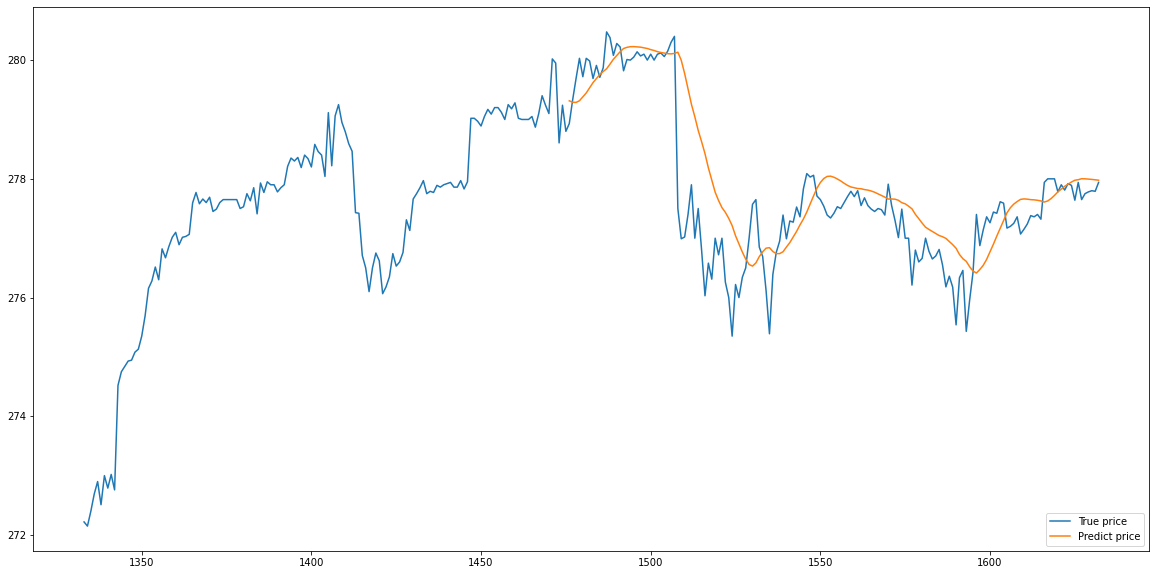

In [376]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/20
40/40 [==============================] - 8s 104ms/step - loss: 0.0264 - val_loss: 3.8243e-04
Epoch 2/20
40/40 [==============================] - 3s 69ms/step - loss: 5.0913e-04 - val_loss: 0.0016
Epoch 3/20
40/40 [==============================] - 3s 69ms/step - loss: 2.4543e-04 - val_loss: 9.8880e-04
Epoch 4/20
40/40 [==============================] - 3s 74ms/step - loss: 2.3707e-04 - val_loss: 6.9615e-04
Epoch 5/20
40/40 [==============================] - 3s 71ms/step - loss: 2.2705e-04 - val_loss: 7.4855e-04
Epoch 6/20
40/40 [==============================] - 3s 71ms/step - loss: 2.3421e-04 - val_loss: 7.1603e-04
Epoch 7/20
40/40 [==============================] - 3s 70ms/step - loss: 2.3325e-04 - val_loss: 0.0015
Epoch 8/20
40/40 [==============================] - 3s 70ms/step - loss: 2.6766e-04 - val_loss: 3.0109e-04
Epoch 9/20
40/40 [==============================] - 3s 71ms/step - loss: 2.1325e-04 - val_loss: 7.0807e-04
Epoch 10/20
40/40 [=============================

<ipython-input-533-c504db07fa02>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


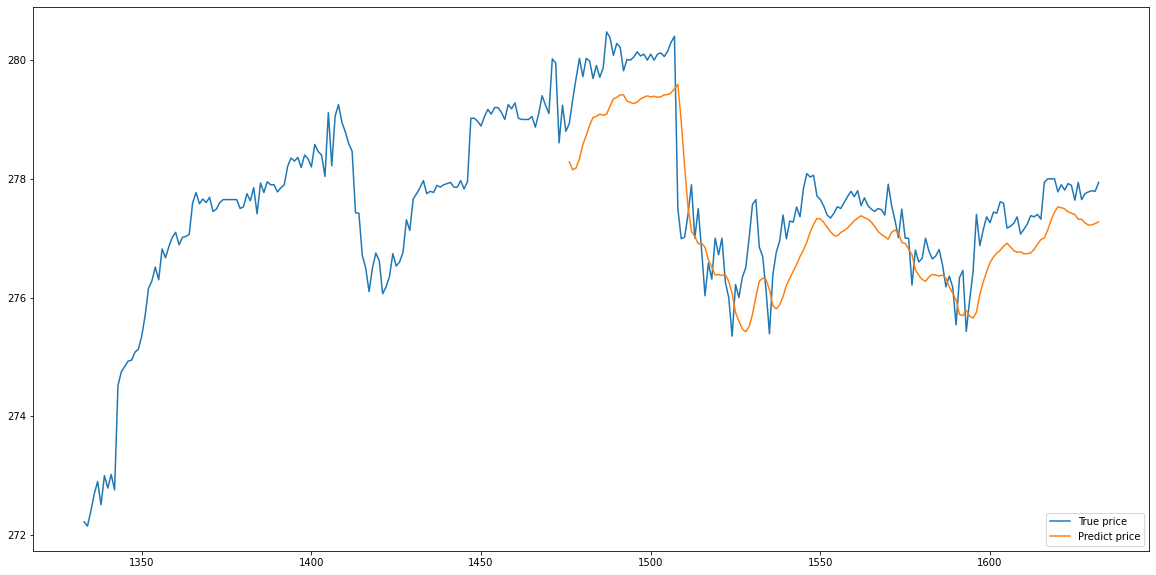

In [533]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/20
40/40 [==============================] - 8s 108ms/step - loss: 0.0555 - val_loss: 0.0168
Epoch 2/20
40/40 [==============================] - 3s 67ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 3/20
40/40 [==============================] - 3s 68ms/step - loss: 5.9720e-04 - val_loss: 0.0023
Epoch 4/20
40/40 [==============================] - 3s 67ms/step - loss: 3.8399e-04 - val_loss: 0.0010
Epoch 5/20
40/40 [==============================] - 3s 68ms/step - loss: 3.4515e-04 - val_loss: 8.5381e-04
Epoch 6/20
40/40 [==============================] - 3s 65ms/step - loss: 3.2796e-04 - val_loss: 6.5984e-04
Epoch 7/20
40/40 [==============================] - 3s 65ms/step - loss: 3.3224e-04 - val_loss: 6.2915e-04
Epoch 8/20
40/40 [==============================] - 3s 74ms/step - loss: 3.0833e-04 - val_loss: 0.0016
Epoch 9/20
40/40 [==============================] - 3s 68ms/step - loss: 3.3129e-04 - val_loss: 9.6632e-04
Epoch 10/20
40/40 [==============================] - 3s 69ms/ste

<ipython-input-534-1c1864d98439>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


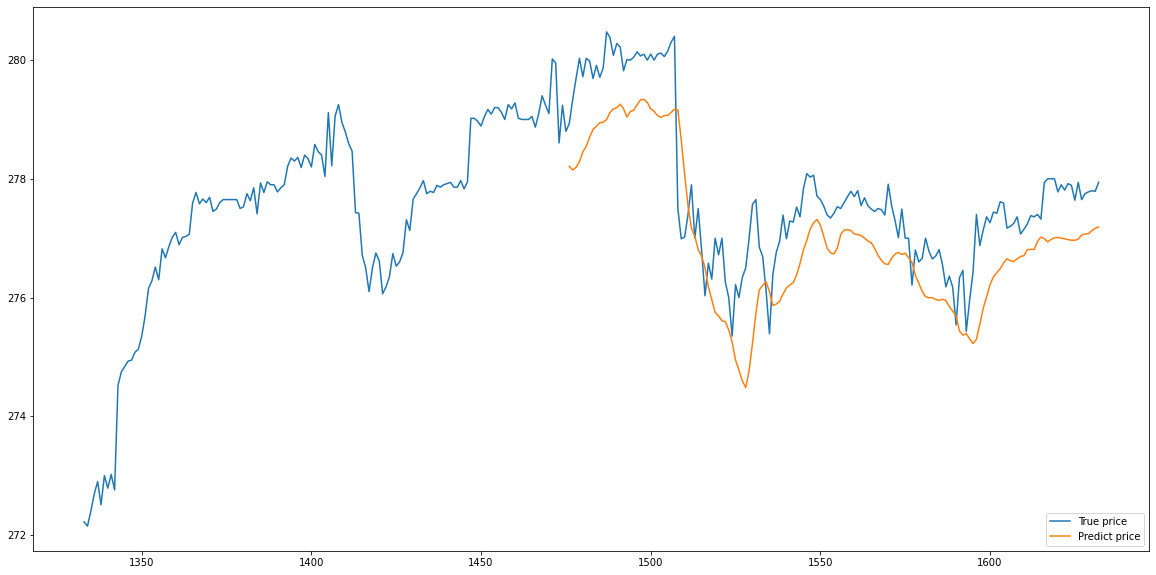

In [534]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/20
40/40 [==============================] - 6s 79ms/step - loss: 0.0753 - val_loss: 0.0141
Epoch 2/20
40/40 [==============================] - 2s 59ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 3/20
40/40 [==============================] - 3s 68ms/step - loss: 4.5579e-04 - val_loss: 0.0011
Epoch 4/20
40/40 [==============================] - 3s 64ms/step - loss: 3.1458e-04 - val_loss: 9.2818e-04
Epoch 5/20
40/40 [==============================] - 2s 61ms/step - loss: 2.6936e-04 - val_loss: 5.6345e-04
Epoch 6/20
40/40 [==============================] - 2s 60ms/step - loss: 2.6831e-04 - val_loss: 0.0012
Epoch 7/20
40/40 [==============================] - 2s 61ms/step - loss: 2.4896e-04 - val_loss: 3.8499e-04
Epoch 8/20
40/40 [==============================] - 2s 62ms/step - loss: 2.8971e-04 - val_loss: 4.8968e-04
Epoch 9/20
40/40 [==============================] - 3s 65ms/step - loss: 2.6628e-04 - val_loss: 5.1442e-04
Epoch 10/20
40/40 [==============================] - 3s 65ms/

<ipython-input-379-b7d0cf1f694c>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


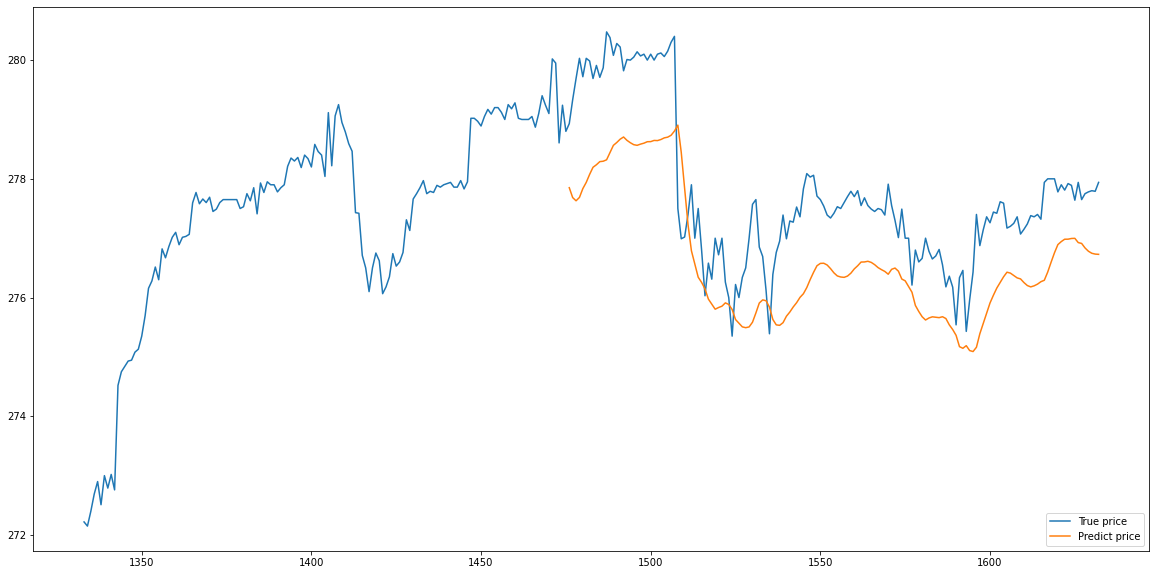

In [379]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/20
40/40 [==============================] - 8s 90ms/step - loss: 0.0359 - val_loss: 7.4390e-04
Epoch 2/20
40/40 [==============================] - 2s 60ms/step - loss: 6.2033e-04 - val_loss: 0.0017
Epoch 3/20
40/40 [==============================] - 2s 62ms/step - loss: 2.9766e-04 - val_loss: 4.8466e-04
Epoch 4/20
40/40 [==============================] - 2s 62ms/step - loss: 2.7992e-04 - val_loss: 6.7994e-04
Epoch 5/20
40/40 [==============================] - 3s 71ms/step - loss: 2.6436e-04 - val_loss: 3.1838e-04
Epoch 6/20
40/40 [==============================] - 2s 62ms/step - loss: 2.4338e-04 - val_loss: 5.4481e-04
Epoch 7/20
40/40 [==============================] - 3s 71ms/step - loss: 2.2755e-04 - val_loss: 7.4353e-04
Epoch 8/20
40/40 [==============================] - 3s 66ms/step - loss: 2.0844e-04 - val_loss: 3.5191e-04
Epoch 9/20
40/40 [==============================] - 3s 64ms/step - loss: 2.2452e-04 - val_loss: 6.5506e-04
Epoch 10/20
40/40 [==========================

<ipython-input-380-60218222a6c2>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


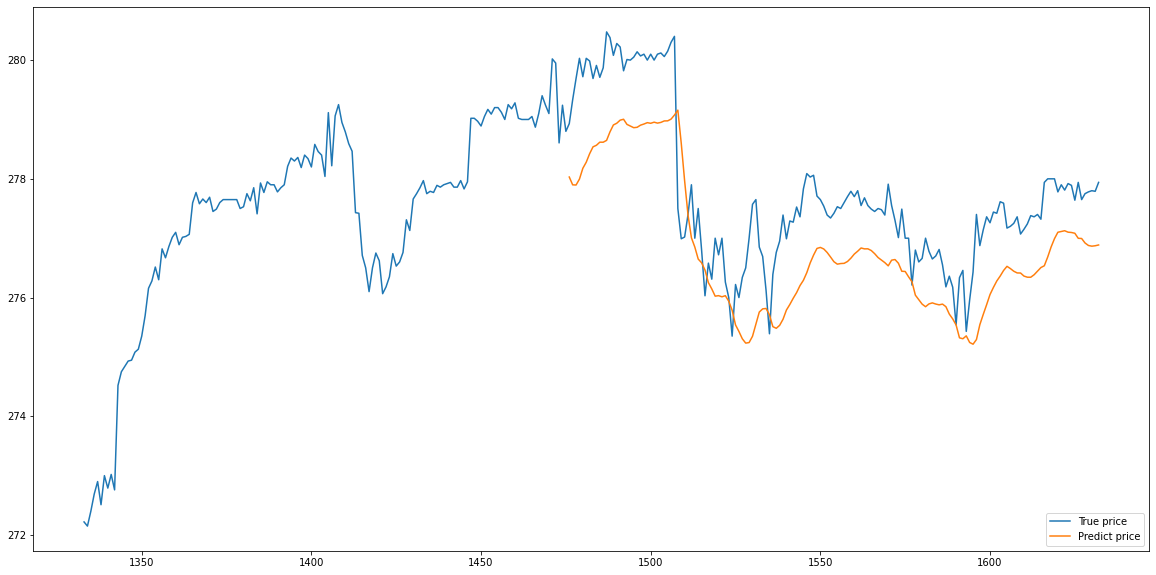

In [380]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/20
40/40 [==============================] - 7s 78ms/step - loss: 0.0272 - val_loss: 0.0030
Epoch 2/20
40/40 [==============================] - 2s 60ms/step - loss: 8.5624e-04 - val_loss: 0.0049
Epoch 3/20
40/40 [==============================] - 2s 60ms/step - loss: 4.5100e-04 - val_loss: 0.0019
Epoch 4/20
40/40 [==============================] - 2s 61ms/step - loss: 4.0123e-04 - val_loss: 7.4097e-04
Epoch 5/20
40/40 [==============================] - 2s 60ms/step - loss: 3.9908e-04 - val_loss: 7.9950e-04
Epoch 6/20
40/40 [==============================] - 2s 62ms/step - loss: 4.0616e-04 - val_loss: 5.6638e-04
Epoch 7/20
40/40 [==============================] - 2s 62ms/step - loss: 3.7477e-04 - val_loss: 0.0017
Epoch 8/20
40/40 [==============================] - 3s 65ms/step - loss: 4.3209e-04 - val_loss: 5.4635e-04
Epoch 9/20
40/40 [==============================] - 3s 66ms/step - loss: 3.3014e-04 - val_loss: 7.8946e-04
Epoch 10/20
40/40 [==============================] - 3s 6

<ipython-input-381-aabebca8d365>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


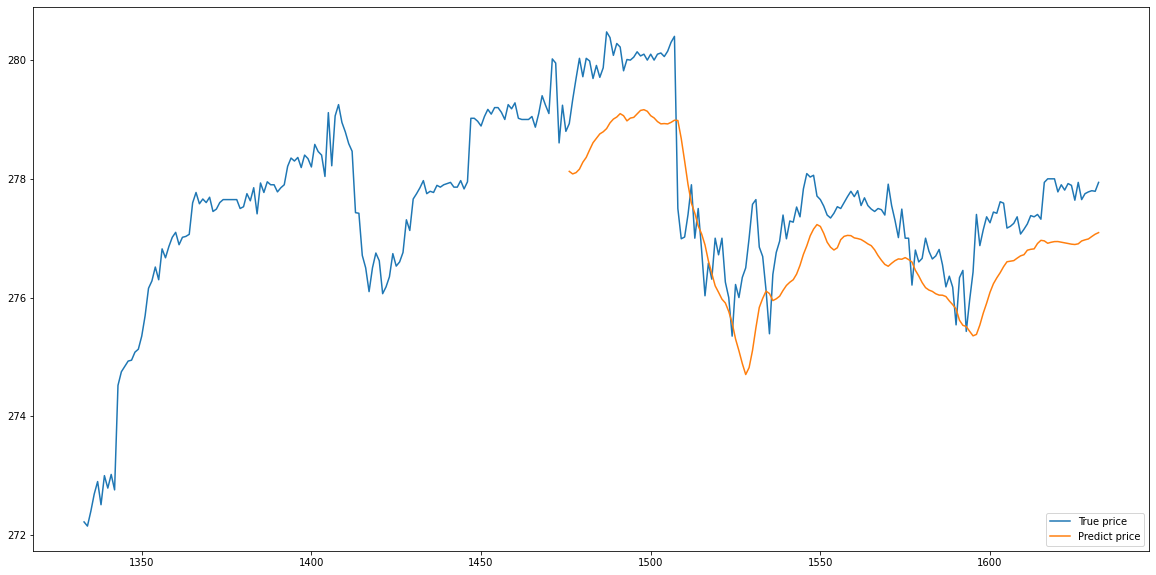

In [381]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/20
40/40 [==============================] - 8s 103ms/step - loss: 0.0537 - val_loss: 0.0089
Epoch 2/20
40/40 [==============================] - 3s 65ms/step - loss: 6.9178e-04 - val_loss: 0.0030
Epoch 3/20
40/40 [==============================] - 3s 66ms/step - loss: 4.5508e-04 - val_loss: 0.0025
Epoch 4/20
40/40 [==============================] - 2s 62ms/step - loss: 3.9819e-04 - val_loss: 0.0019
Epoch 5/20
40/40 [==============================] - 3s 68ms/step - loss: 3.5743e-04 - val_loss: 0.0012
Epoch 6/20
40/40 [==============================] - 3s 70ms/step - loss: 3.4767e-04 - val_loss: 6.5169e-04
Epoch 7/20
40/40 [==============================] - 3s 65ms/step - loss: 3.3078e-04 - val_loss: 8.1473e-04
Epoch 8/20
40/40 [==============================] - 3s 65ms/step - loss: 2.9024e-04 - val_loss: 9.6140e-04
Epoch 9/20
40/40 [==============================] - 3s 64ms/step - loss: 2.7001e-04 - val_loss: 7.9747e-04
Epoch 10/20
40/40 [==============================] - 3s 67ms

<ipython-input-382-04ba49a28a5b>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


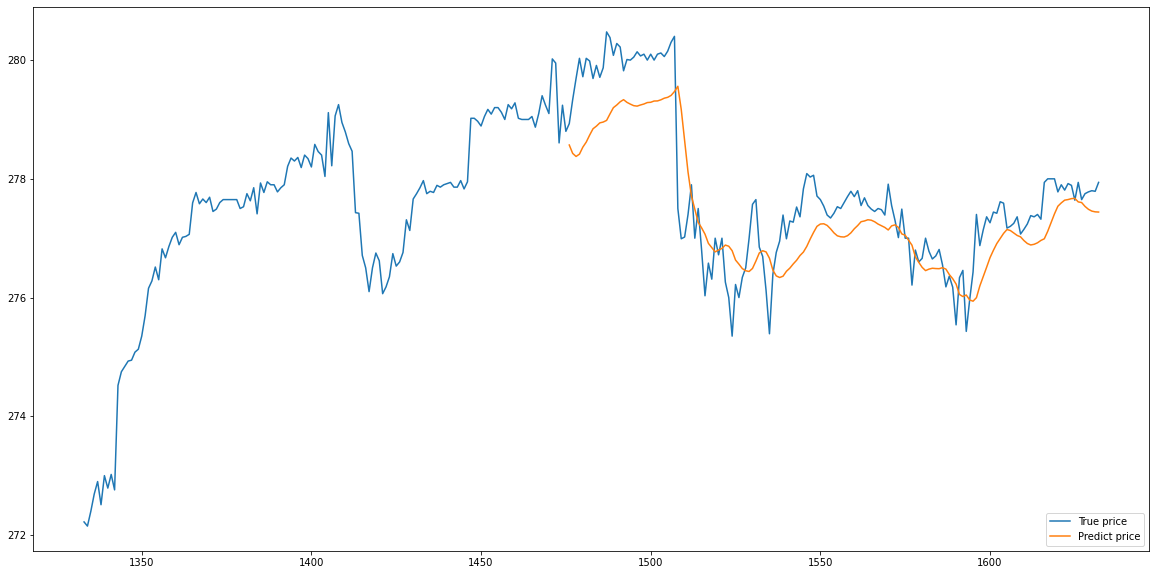

In [382]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/20
40/40 [==============================] - 7s 89ms/step - loss: 0.0529 - val_loss: 0.0011
Epoch 2/20
40/40 [==============================] - 3s 70ms/step - loss: 8.9912e-04 - val_loss: 0.0025
Epoch 3/20
40/40 [==============================] - 3s 64ms/step - loss: 4.0370e-04 - val_loss: 8.3655e-04
Epoch 4/20
40/40 [==============================] - 3s 67ms/step - loss: 3.0923e-04 - val_loss: 6.5819e-04
Epoch 5/20
40/40 [==============================] - 3s 66ms/step - loss: 2.4535e-04 - val_loss: 3.9520e-04
Epoch 6/20
40/40 [==============================] - 3s 66ms/step - loss: 2.4454e-04 - val_loss: 8.6252e-04
Epoch 7/20
40/40 [==============================] - 3s 69ms/step - loss: 2.0795e-04 - val_loss: 8.9375e-04
Epoch 8/20
40/40 [==============================] - 3s 67ms/step - loss: 2.3564e-04 - val_loss: 6.4109e-04
Epoch 9/20
40/40 [==============================] - 3s 68ms/step - loss: 2.4162e-04 - val_loss: 3.3494e-04
Epoch 10/20
40/40 [==============================

<ipython-input-383-0cbee2e2e209>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


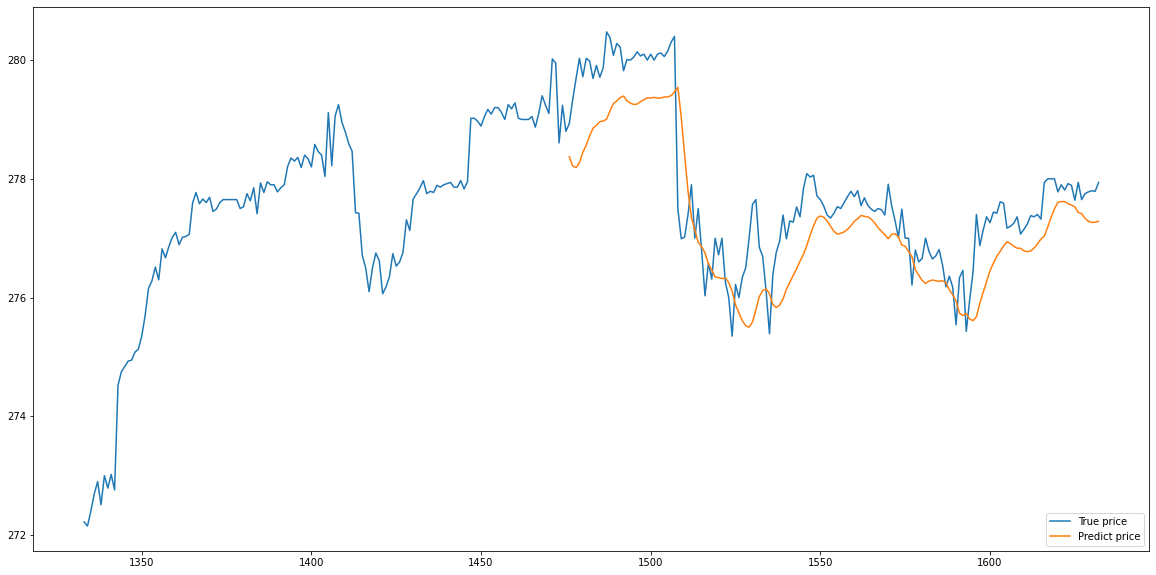

In [383]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/20
40/40 [==============================] - 8s 85ms/step - loss: 0.0391 - val_loss: 6.8964e-04
Epoch 2/20
40/40 [==============================] - 3s 63ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 3/20
40/40 [==============================] - 3s 62ms/step - loss: 3.8382e-04 - val_loss: 0.0030
Epoch 4/20
40/40 [==============================] - 3s 63ms/step - loss: 3.0922e-04 - val_loss: 0.0012
Epoch 5/20
40/40 [==============================] - 3s 68ms/step - loss: 2.7819e-04 - val_loss: 8.9701e-04
Epoch 6/20
40/40 [==============================] - 3s 64ms/step - loss: 2.9213e-04 - val_loss: 0.0012
Epoch 7/20
40/40 [==============================] - 3s 63ms/step - loss: 2.2911e-04 - val_loss: 9.7349e-04
Epoch 8/20
40/40 [==============================] - 3s 64ms/step - loss: 2.3354e-04 - val_loss: 8.9725e-04
Epoch 9/20
40/40 [==============================] - 3s 63ms/step - loss: 2.3164e-04 - val_loss: 0.0013
Epoch 10/20
40/40 [==============================] - 3s 64ms/step

<ipython-input-384-1f8253baa681>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


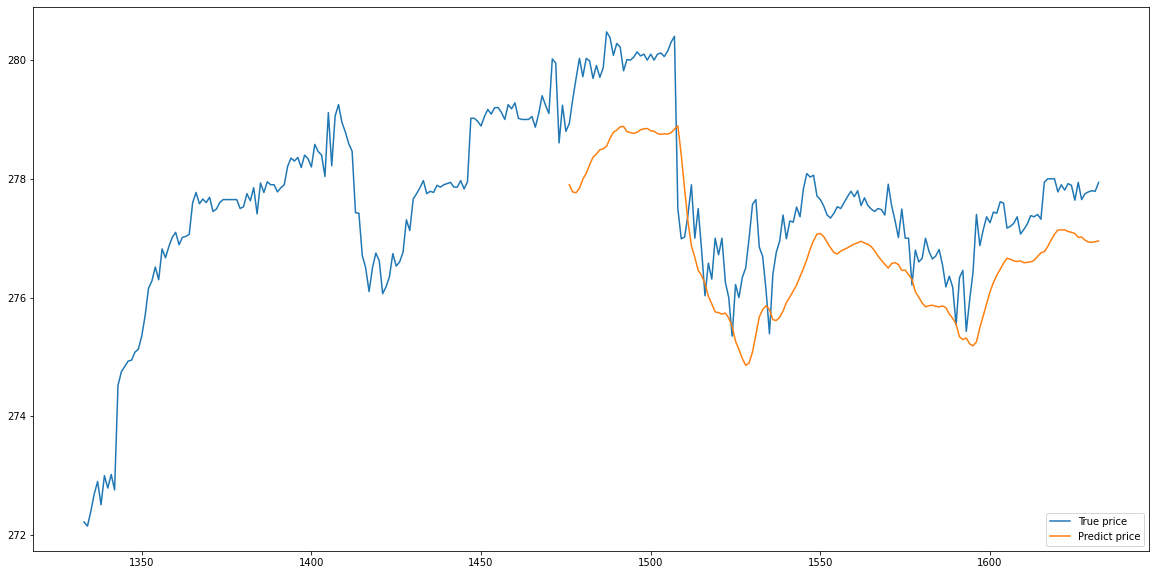

In [384]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### e. Predict Future

In [253]:
def lstm_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.h5'
    model = load_model(modelFileName)
    numDataPoint = int(period / 15)
    
    data = data[indicatorArr].values
    data = data[-60:]

    scaler = MinMaxScaler(feature_range=(0,1))
    scaledData = scaler.fit_transform(data)

    modelInput = scaledData.reshape(-1, scaledData.shape[0], scaledData.shape[1])

    predictedScaledValue = model.predict(modelInput)

    predictedValue = scaler.inverse_transform(np.tile(predictedScaledValue, (1, scaledData.shape[1])))[:, 0]
    
    return predictedValue

## 2. RNN

### a. Prepare Input

In [432]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[248.88],
       [248.64],
       [248.69],
       ...,
       [277.8 ],
       [277.79],
       [277.94]])

In [433]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.15385645],
       [0.14742903],
       [0.14876808],
       ...,
       [0.92836101],
       [0.9280932 ],
       [0.93211034]])

In [434]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1573
1573


In [435]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1259, 60, 1)
Size validate:  (157, 60, 1)
Size test:  (157, 60, 1)


### b. Train Model

In [421]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN.h5")

Epoch 1/25
40/40 [==============================] - 13s 142ms/step - loss: 0.0586 - val_loss: 9.2056e-04
Epoch 2/25
40/40 [==============================] - 4s 101ms/step - loss: 0.0057 - val_loss: 0.0021
Epoch 3/25
40/40 [==============================] - 4s 104ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 4/25
40/40 [==============================] - 4s 104ms/step - loss: 0.0033 - val_loss: 0.0102
Epoch 5/25
40/40 [==============================] - 4s 110ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 6/25
40/40 [==============================] - 4s 109ms/step - loss: 0.0028 - val_loss: 0.0050
Epoch 7/25
40/40 [==============================] - 4s 110ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 8/25
40/40 [==============================] - 4s 111ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 9/25
40/40 [==============================] - 5s 113ms/step - loss: 0.0024 - val_loss: 7.8375e-04
Epoch 10/25
40/40 [==============================] - 5s 123ms/step - loss: 0.0025 - val_los

### c. Test Model

In [436]:
model_rnn = load_model('./MODEL/RNN.h5')

In [437]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [438]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-438-665481fb171d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


date      open    high       low     close    volume  \
1476  2021-07-07 11:30:00  278.8400  278.97  278.5500  278.9300  624508.0   
1477  2021-07-07 11:45:00  278.9450  279.35  278.5200  279.3314  570070.0   
1478  2021-07-07 12:00:00  279.3200  279.98  279.3200  279.6900  510257.0   
1479  2021-07-07 12:15:00  279.7050  280.23  279.6600  280.0300  527682.0   
1480  2021-07-07 12:30:00  280.0500  280.24  279.7000  279.7200  661221.0   
...                   ...       ...     ...       ...       ...       ...   
1628  2021-07-09 19:00:00  277.7499  277.75  277.7499  277.7500    1611.0   
1629  2021-07-09 19:15:00  277.7800  277.78  277.7800  277.7800     220.0   
1630  2021-07-09 19:30:00  277.7900  277.80  277.7900  277.8000    1053.0   
1631  2021-07-09 19:45:00  277.8000  277.80  277.7900  277.7900    1233.0   
1632  2021-07-09 20:00:00  277.8000  277.94  277.8000  277.9400    1600.0   

         ROC       SMA      RSI  Real Lower Band  Real Upper Band  \
1476 -0.0681  279.1518  51.1594         278.4927         279.8108   
1477  0.1188  279.1683  54.7801         278.5087         279.8279   
1478  0.1576  279.1903  57.7271         278.4930         279.8876   
1479  0.3045  279.2328  60.3087         278.4454         280.0202   
1480  0.1575  279.2548  56.9696         278.4393         280.0703   
...      ...       ...      ...              ...              ...   
1628  0.1406  277.6570  53.8171         277.0466         278.2674   
1629  0.2563  277.6925  54.1876         277.1432         278.2418   
1630  0.2345  277.7250  54.4440         277.2341         278.2159   
1631  0.1984  277.7525  54.2841         277.3146         278.1904   
1632  0.2019  277.7805  56.3105         277.3708         278.1902   

      Real Middle Band  predictions  
1476          279.1518   277.731659  
1477          279.1683   277.744080  
1478          279.1903   277.751099  
1479          279.2328   277.755981  
1480          279.2548   277.763855  
...                ...          ...  
1628          277.6570   276.505188  
1629          277.6925   276.527466  
1630          277.7250   276.543671  
1631          277.7525   276.554535  
1632          277.7805   276.561127  

[157 rows x 13 columns]

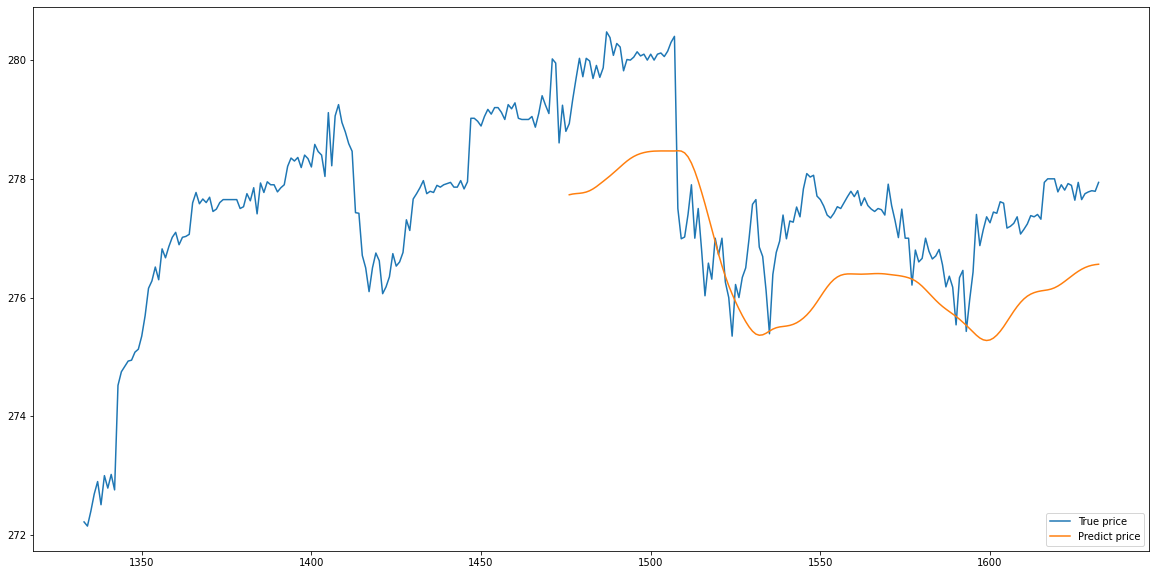

In [440]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [394]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 2.4888e+02, -9.1170e-01],
       [ 2.4864e+02, -8.7310e-01],
       [ 2.4869e+02, -9.1640e-01],
       ...,
       [ 2.7780e+02,  2.3450e-01],
       [ 2.7779e+02,  1.9840e-01],
       [ 2.7794e+02,  2.0190e-01]])

In [395]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.15385645, 0.21469751],
       [0.14742903, 0.22363455],
       [0.14876808, 0.21360932],
       ...,
       [0.92836101, 0.48007687],
       [0.9280932 , 0.47171865],
       [0.93211034, 0.472529  ]])

In [396]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1573
1573


In [397]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1259, 60, 2)
Size validate:  (157, 60, 2)
Size test:  (157, 60, 2)


In [398]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC.h5")

Epoch 1/25
40/40 [==============================] - 14s 193ms/step - loss: 0.0470 - val_loss: 0.0050
Epoch 2/25
40/40 [==============================] - 4s 112ms/step - loss: 0.0037 - val_loss: 0.0061
Epoch 3/25
40/40 [==============================] - 4s 112ms/step - loss: 0.0031 - val_loss: 0.0053
Epoch 4/25
40/40 [==============================] - 5s 128ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 5/25
40/40 [==============================] - 5s 116ms/step - loss: 0.0030 - val_loss: 0.0085
Epoch 6/25
40/40 [==============================] - 5s 116ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 7/25
40/40 [==============================] - 5s 119ms/step - loss: 0.0026 - val_loss: 7.7015e-04
Epoch 8/25
40/40 [==============================] - 5s 131ms/step - loss: 0.0024 - val_loss: 5.5139e-04
Epoch 9/25
40/40 [==============================] - 5s 121ms/step - loss: 0.0030 - val_loss: 0.0039
Epoch 10/25
40/40 [==============================] - 5s 119ms/step - loss: 0.0024 - val_los

In [399]:
model_rnn = load_model('./MODEL/RNN_ROC.h5')

In [400]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, 2)))[:, 0]

In [401]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-401-665481fb171d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


date      open    high       low     close    volume  \
1476  2021-07-07 11:30:00  278.8400  278.97  278.5500  278.9300  624508.0   
1477  2021-07-07 11:45:00  278.9450  279.35  278.5200  279.3314  570070.0   
1478  2021-07-07 12:00:00  279.3200  279.98  279.3200  279.6900  510257.0   
1479  2021-07-07 12:15:00  279.7050  280.23  279.6600  280.0300  527682.0   
1480  2021-07-07 12:30:00  280.0500  280.24  279.7000  279.7200  661221.0   
...                   ...       ...     ...       ...       ...       ...   
1628  2021-07-09 19:00:00  277.7499  277.75  277.7499  277.7500    1611.0   
1629  2021-07-09 19:15:00  277.7800  277.78  277.7800  277.7800     220.0   
1630  2021-07-09 19:30:00  277.7900  277.80  277.7900  277.8000    1053.0   
1631  2021-07-09 19:45:00  277.8000  277.80  277.7900  277.7900    1233.0   
1632  2021-07-09 20:00:00  277.8000  277.94  277.8000  277.9400    1600.0   

         ROC       SMA      RSI  Real Lower Band  Real Upper Band  \
1476 -0.0681  279.1518  51.1594         278.4927         279.8108   
1477  0.1188  279.1683  54.7801         278.5087         279.8279   
1478  0.1576  279.1903  57.7271         278.4930         279.8876   
1479  0.3045  279.2328  60.3087         278.4454         280.0202   
1480  0.1575  279.2548  56.9696         278.4393         280.0703   
...      ...       ...      ...              ...              ...   
1628  0.1406  277.6570  53.8171         277.0466         278.2674   
1629  0.2563  277.6925  54.1876         277.1432         278.2418   
1630  0.2345  277.7250  54.4440         277.2341         278.2159   
1631  0.1984  277.7525  54.2841         277.3146         278.1904   
1632  0.2019  277.7805  56.3105         277.3708         278.1902   

      Real Middle Band  predictions  
1476          279.1518   277.605072  
1477          279.1683   277.592285  
1478          279.1903   277.579712  
1479          279.2328   277.573303  
1480          279.2548   277.579926  
...                ...          ...  
1628          277.6570   276.536926  
1629          277.6925   276.539185  
1630          277.7250   276.545166  
1631          277.7525   276.554993  
1632          277.7805   276.567596  

[157 rows x 13 columns]

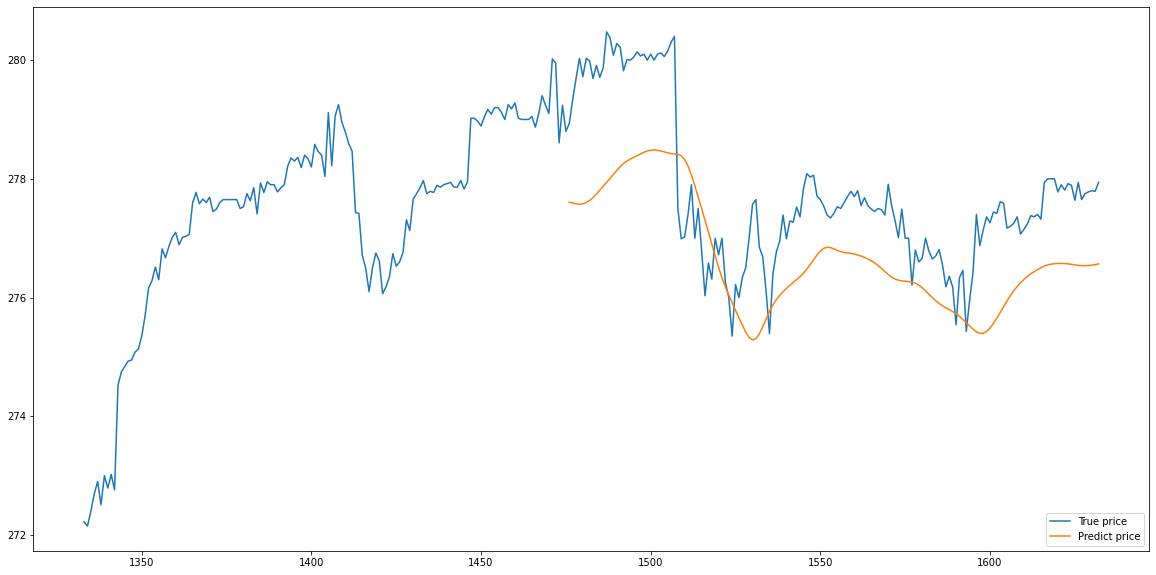

In [402]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/25
40/40 [==============================] - 13s 141ms/step - loss: 0.0582 - val_loss: 0.0305
Epoch 2/25
40/40 [==============================] - 4s 110ms/step - loss: 0.0053 - val_loss: 0.0175
Epoch 3/25
40/40 [==============================] - 5s 124ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 4/25
40/40 [==============================] - 4s 107ms/step - loss: 0.0040 - val_loss: 0.0010
Epoch 5/25
40/40 [==============================] - 4s 111ms/step - loss: 0.0030 - val_loss: 0.0052
Epoch 6/25
40/40 [==============================] - 5s 116ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 7/25
40/40 [==============================] - 5s 126ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 8/25
40/40 [==============================] - 6s 139ms/step - loss: 0.0029 - val_loss: 0.0152
Epoch 9/25
40/40 [==============================] - 5s 115ms/step - loss: 0.0040 - val_loss: 0.0137
Epoch 10/25
40/40 [==============================] - 5s 127ms/step - loss: 0.0029 - val_loss: 0.001

<ipython-input-403-7df784750a12>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


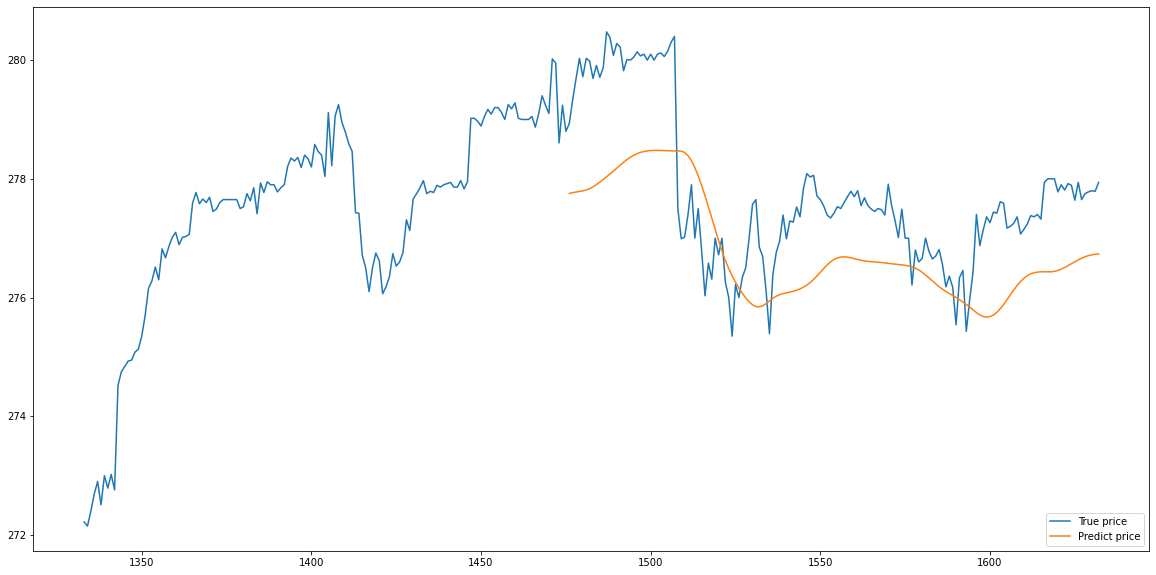

In [403]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_SMA.h5")

model_rnn = load_model('./MODEL/RNN_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/25
40/40 [==============================] - 14s 169ms/step - loss: 0.0570 - val_loss: 0.0013
Epoch 2/25
40/40 [==============================] - 4s 107ms/step - loss: 0.0049 - val_loss: 0.0028
Epoch 3/25
40/40 [==============================] - 4s 111ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 4/25
40/40 [==============================] - 4s 112ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 5/25
40/40 [==============================] - 5s 112ms/step - loss: 0.0028 - val_loss: 0.0086
Epoch 6/25
40/40 [==============================] - 5s 115ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 7/25
40/40 [==============================] - 5s 114ms/step - loss: 0.0024 - val_loss: 6.9453e-04
Epoch 8/25
40/40 [==============================] - 5s 121ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 9/25
40/40 [==============================] - 5s 116ms/step - loss: 0.0023 - val_loss: 7.0541e-04
Epoch 10/25
40/40 [==============================] - 5s 117ms/step - loss: 0.0027 - val_los

<ipython-input-404-e352288f4878>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


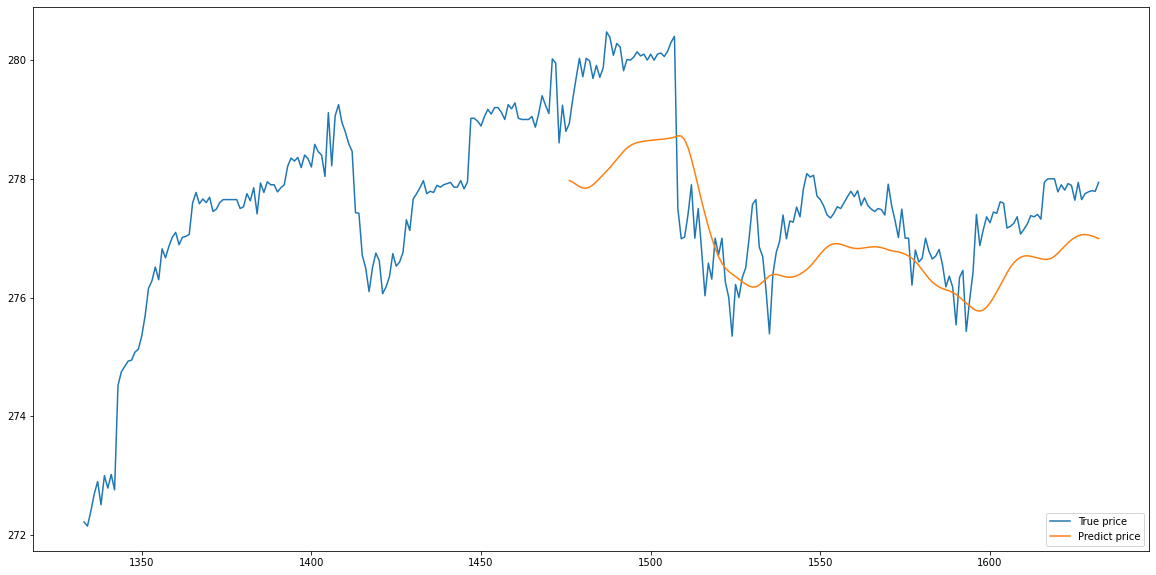

In [404]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI.h5")

model_rnn = load_model('./MODEL/RNN_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/25
40/40 [==============================] - 15s 158ms/step - loss: 0.0523 - val_loss: 0.0231
Epoch 2/25
40/40 [==============================] - 5s 118ms/step - loss: 0.0052 - val_loss: 0.0194
Epoch 3/25
40/40 [==============================] - 5s 123ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 4/25
40/40 [==============================] - 5s 121ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 5/25
40/40 [==============================] - 5s 123ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 6/25
40/40 [==============================] - 5s 125ms/step - loss: 0.0035 - val_loss: 0.0094
Epoch 7/25
40/40 [==============================] - 5s 128ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 8/25
40/40 [==============================] - 5s 129ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 9/25
40/40 [==============================] - 5s 127ms/step - loss: 0.0028 - val_loss: 8.5368e-04
Epoch 10/25
40/40 [==============================] - 5s 129ms/step - loss: 0.0029 - val_loss: 0

<ipython-input-535-d527ed06458f>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


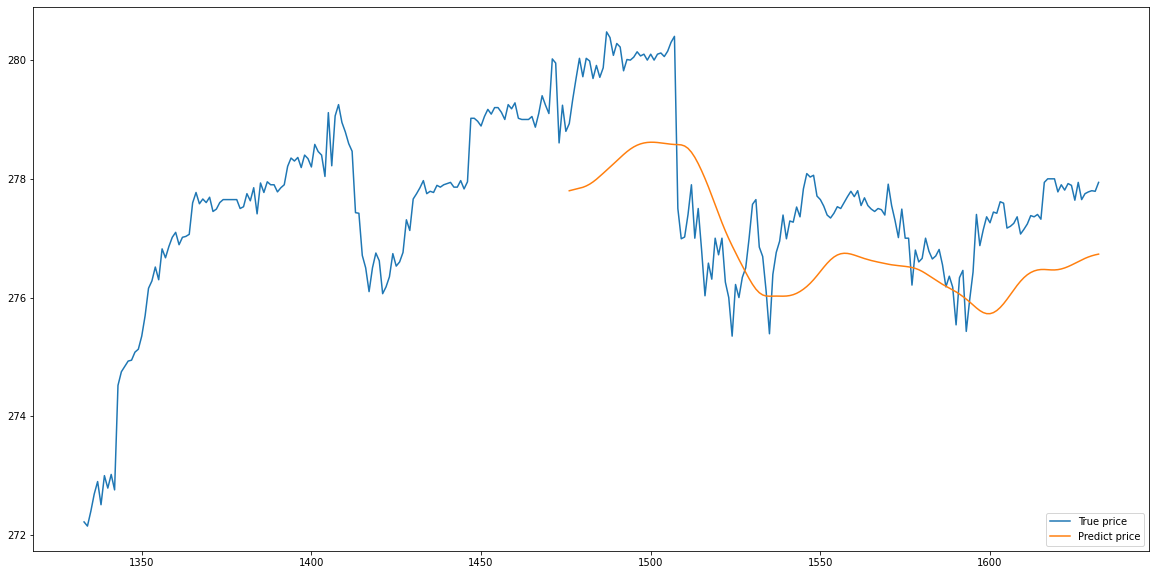

In [535]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/25
40/40 [==============================] - 17s 219ms/step - loss: 0.0553 - val_loss: 0.0389
Epoch 2/25
40/40 [==============================] - 6s 140ms/step - loss: 0.0058 - val_loss: 0.0079
Epoch 3/25
40/40 [==============================] - 6s 137ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 4/25
40/40 [==============================] - 6s 143ms/step - loss: 0.0036 - val_loss: 0.0064
Epoch 5/25
40/40 [==============================] - 6s 140ms/step - loss: 0.0031 - val_loss: 0.0130
Epoch 6/25
40/40 [==============================] - 6s 139ms/step - loss: 0.0032 - val_loss: 0.0157
Epoch 7/25
40/40 [==============================] - 6s 137ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 8/25
40/40 [==============================] - 6s 139ms/step - loss: 0.0030 - val_loss: 0.0052
Epoch 9/25
40/40 [==============================] - 6s 154ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 10/25
40/40 [==============================] - 6s 139ms/step - loss: 0.0024 - val_loss: 0.005

<ipython-input-536-e6ab193b1923>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


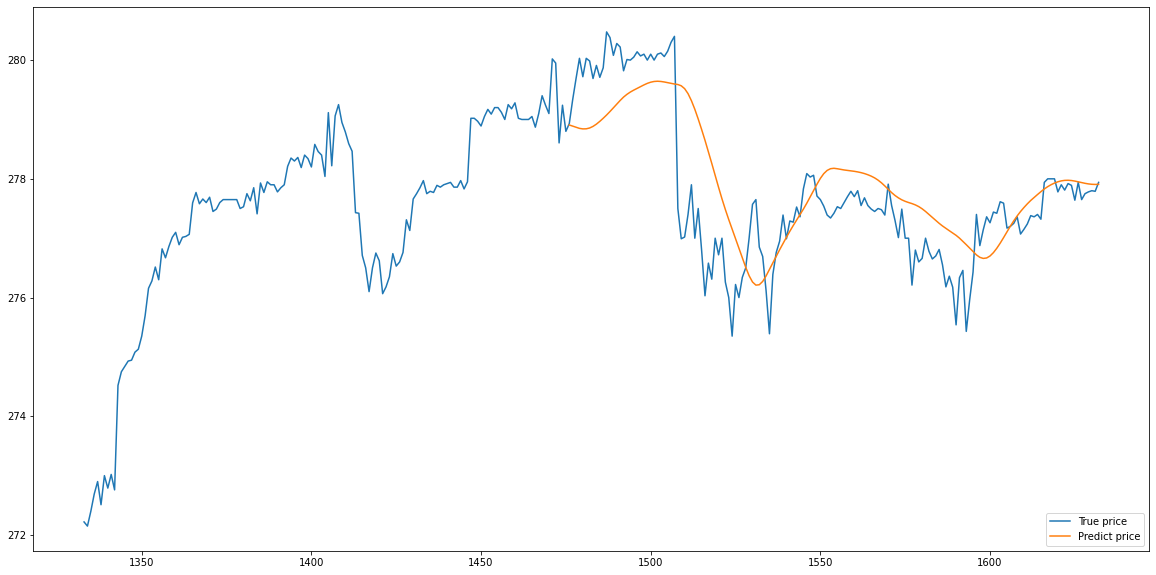

In [536]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/25
40/40 [==============================] - 16s 182ms/step - loss: 0.0573 - val_loss: 0.0436
Epoch 2/25
40/40 [==============================] - 5s 126ms/step - loss: 0.0052 - val_loss: 0.0151
Epoch 3/25
40/40 [==============================] - 5s 131ms/step - loss: 0.0039 - val_loss: 0.0086
Epoch 4/25
40/40 [==============================] - 5s 130ms/step - loss: 0.0033 - val_loss: 5.4733e-04
Epoch 5/25
40/40 [==============================] - 6s 148ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 6/25
40/40 [==============================] - 5s 131ms/step - loss: 0.0030 - val_loss: 8.6702e-04
Epoch 7/25
40/40 [==============================] - 5s 134ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 8/25
40/40 [==============================] - 6s 138ms/step - loss: 0.0025 - val_loss: 0.0059
Epoch 9/25
40/40 [==============================] - 6s 155ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 10/25
40/40 [==============================] - 5s 134ms/step - loss: 0.0024 - val_los

<ipython-input-537-a7314ebbd818>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


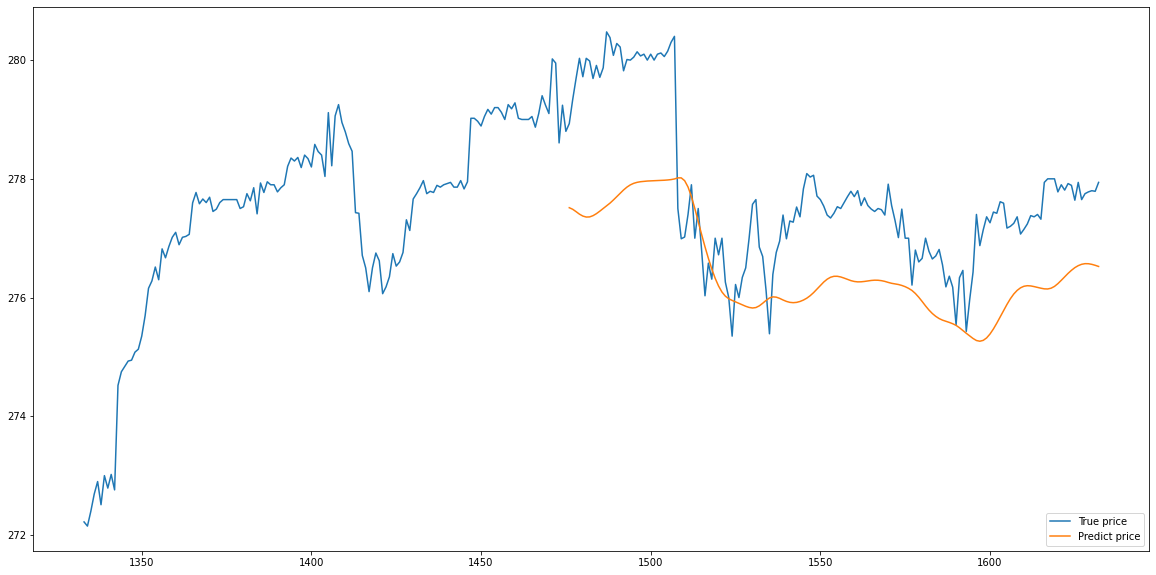

In [537]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/25
40/40 [==============================] - 15s 193ms/step - loss: 0.0554 - val_loss: 0.0173
Epoch 2/25
40/40 [==============================] - 6s 158ms/step - loss: 0.0039 - val_loss: 0.0127
Epoch 3/25
40/40 [==============================] - 6s 148ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 4/25
40/40 [==============================] - 5s 135ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 5/25
40/40 [==============================] - 6s 139ms/step - loss: 0.0040 - val_loss: 0.0067
Epoch 6/25
40/40 [==============================] - 6s 140ms/step - loss: 0.0031 - val_loss: 9.5491e-04
Epoch 7/25
40/40 [==============================] - 5s 137ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 8/25
40/40 [==============================] - 5s 125ms/step - loss: 0.0037 - val_loss: 0.0073
Epoch 9/25
40/40 [==============================] - 5s 126ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 10/25
40/40 [==============================] - 5s 126ms/step - loss: 0.0028 - val_loss: 0

<ipython-input-538-5d468a69cadd>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


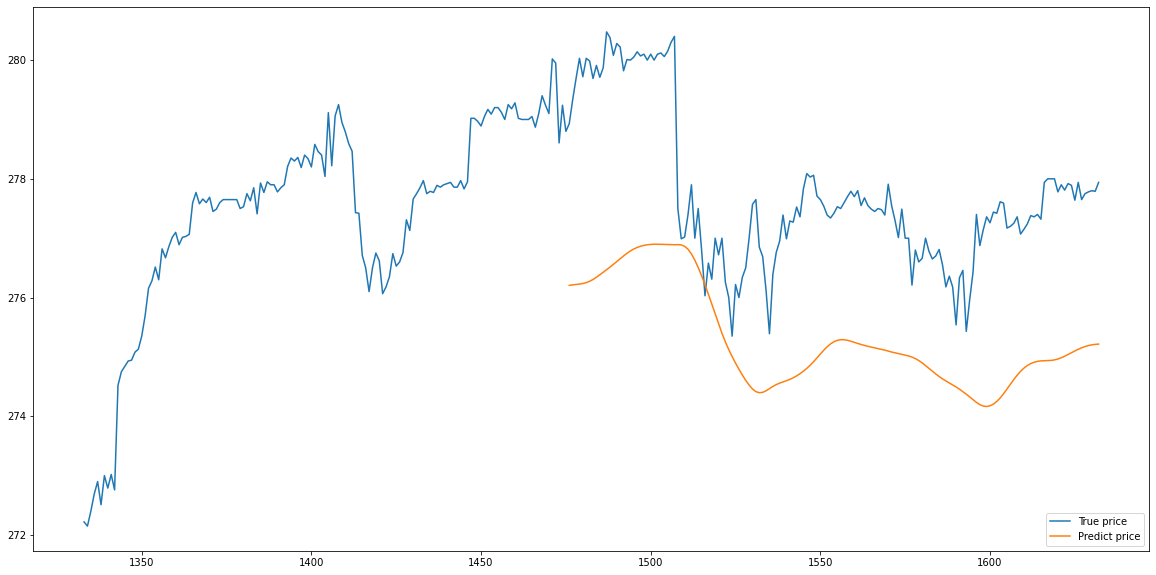

In [538]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/25
40/40 [==============================] - 12s 155ms/step - loss: 0.0575 - val_loss: 0.0021
Epoch 2/25
40/40 [==============================] - 4s 108ms/step - loss: 0.0047 - val_loss: 0.0019
Epoch 3/25
40/40 [==============================] - 5s 122ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 4/25
40/40 [==============================] - 5s 114ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 5/25
40/40 [==============================] - 5s 128ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 6/25
40/40 [==============================] - 5s 117ms/step - loss: 0.0025 - val_loss: 9.6641e-04
Epoch 7/25
40/40 [==============================] - 5s 117ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 8/25
40/40 [==============================] - 5s 117ms/step - loss: 0.0023 - val_loss: 0.0051
Epoch 9/25
40/40 [==============================] - 5s 124ms/step - loss: 0.0023 - val_loss: 5.1384e-04
Epoch 10/25
40/40 [==============================] - 5s 118ms/step - loss: 0.0028 - val_los

<ipython-input-442-38de6d8afd4a>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


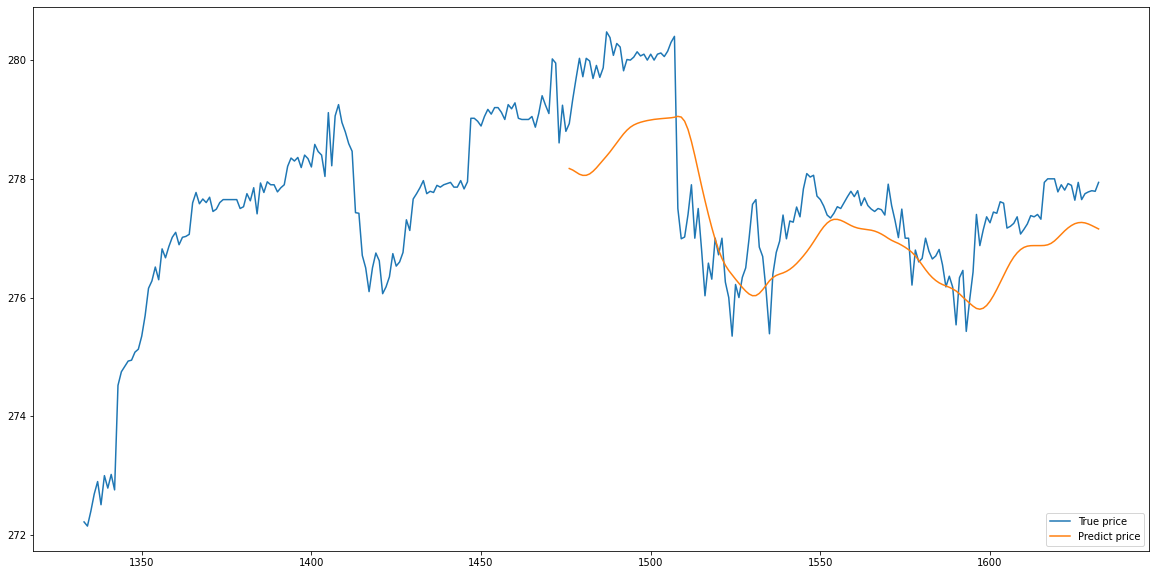

In [442]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/25
40/40 [==============================] - 13s 173ms/step - loss: 0.0530 - val_loss: 0.0142
Epoch 2/25
40/40 [==============================] - 5s 116ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 3/25
40/40 [==============================] - 5s 113ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 4/25
40/40 [==============================] - 5s 115ms/step - loss: 0.0030 - val_loss: 9.1737e-04
Epoch 5/25
40/40 [==============================] - 4s 112ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 6/25
40/40 [==============================] - 5s 117ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 7/25
40/40 [==============================] - 5s 122ms/step - loss: 0.0026 - val_loss: 0.0079
Epoch 8/25
40/40 [==============================] - 5s 134ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 9/25
40/40 [==============================] - 5s 120ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 10/25
40/40 [==============================] - 5s 135ms/step - loss: 0.0024 - val_loss: 0

<ipython-input-443-db883154e7ee>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


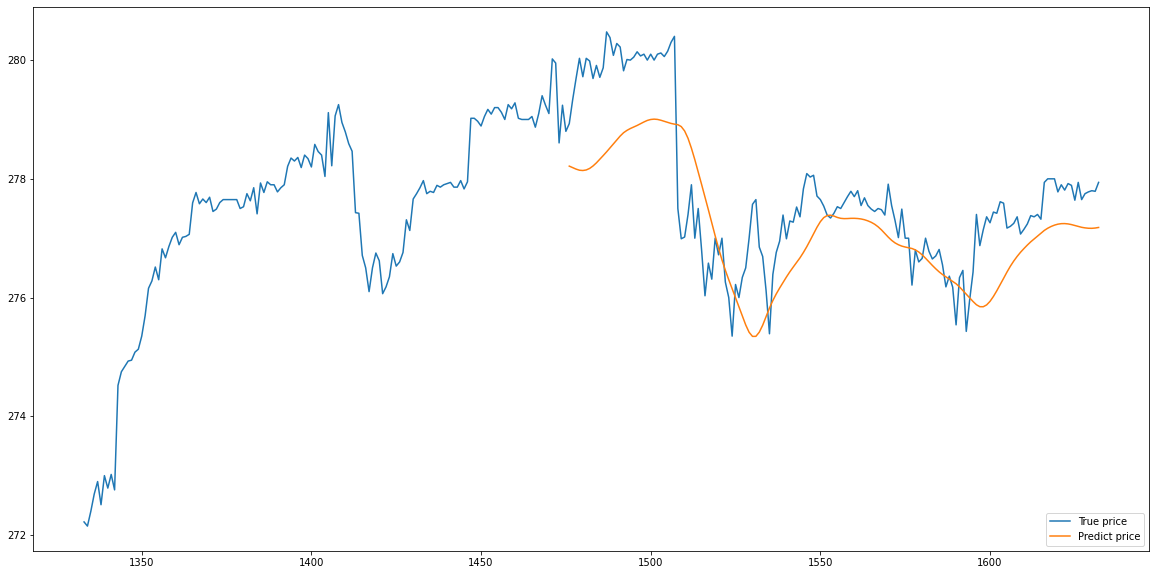

In [443]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/25
40/40 [==============================] - 12s 144ms/step - loss: 0.0615 - val_loss: 0.0228
Epoch 2/25
40/40 [==============================] - 4s 101ms/step - loss: 0.0040 - val_loss: 0.0070
Epoch 3/25
40/40 [==============================] - 4s 107ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 4/25
40/40 [==============================] - 4s 105ms/step - loss: 0.0027 - val_loss: 0.0113
Epoch 5/25
40/40 [==============================] - 4s 111ms/step - loss: 0.0029 - val_loss: 5.3811e-04
Epoch 6/25
40/40 [==============================] - 4s 108ms/step - loss: 0.0027 - val_loss: 6.9011e-04
Epoch 7/25
40/40 [==============================] - 4s 111ms/step - loss: 0.0025 - val_loss: 0.0043
Epoch 8/25
40/40 [==============================] - 5s 124ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 9/25
40/40 [==============================] - 5s 113ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 10/25
40/40 [==============================] - 5s 113ms/step - loss: 0.0022 - val_los

<ipython-input-444-18205f3ea835>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


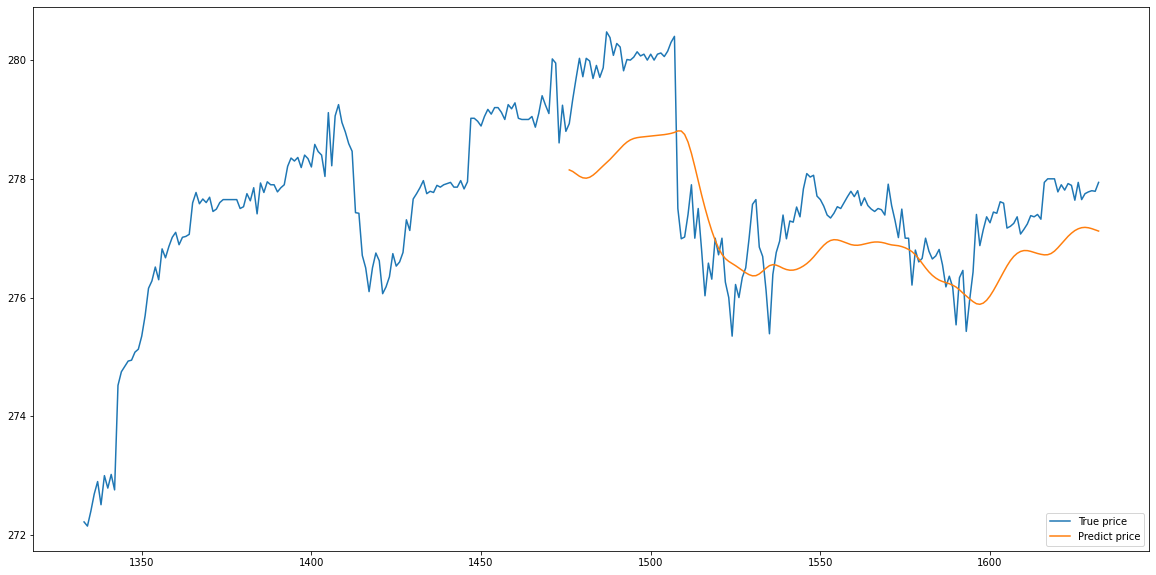

In [444]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/25
40/40 [==============================] - 17s 181ms/step - loss: 0.0696 - val_loss: 0.0434
Epoch 2/25
40/40 [==============================] - 5s 137ms/step - loss: 0.0049 - val_loss: 0.0098
Epoch 3/25
40/40 [==============================] - 6s 158ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 4/25
40/40 [==============================] - 5s 137ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/25
40/40 [==============================] - 5s 131ms/step - loss: 0.0028 - val_loss: 0.0070
Epoch 6/25
40/40 [==============================] - 5s 128ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 7/25
40/40 [==============================] - 5s 128ms/step - loss: 0.0027 - val_loss: 0.0073
Epoch 8/25
40/40 [==============================] - 5s 129ms/step - loss: 0.0023 - val_loss: 0.0047
Epoch 9/25
40/40 [==============================] - 6s 147ms/step - loss: 0.0022 - val_loss: 0.0130
Epoch 10/25
40/40 [==============================] - 5s 128ms/step - loss: 0.0032 - val_loss: 0.015

<ipython-input-539-6e2f3bb49f3c>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


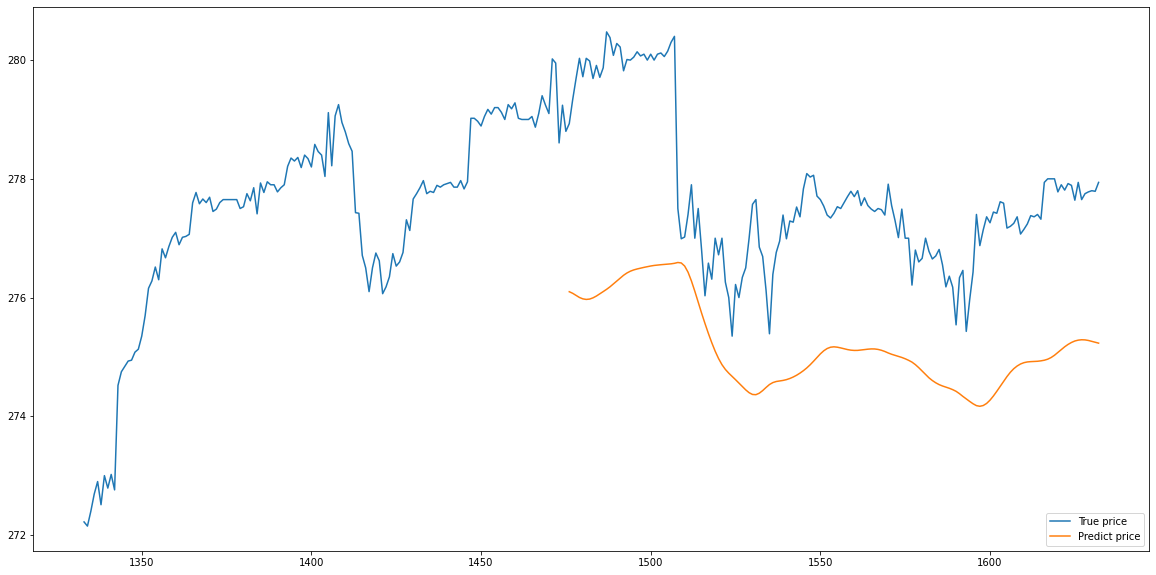

In [539]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/25
40/40 [==============================] - 17s 211ms/step - loss: 0.0654 - val_loss: 0.0188
Epoch 2/25
40/40 [==============================] - 5s 132ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 3/25
40/40 [==============================] - 5s 129ms/step - loss: 0.0033 - val_loss: 0.0080
Epoch 4/25
40/40 [==============================] - 5s 126ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 5/25
40/40 [==============================] - 5s 127ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 6/25
40/40 [==============================] - 5s 129ms/step - loss: 0.0031 - val_loss: 0.0072
Epoch 7/25
40/40 [==============================] - 5s 128ms/step - loss: 0.0028 - val_loss: 8.8908e-04
Epoch 8/25
40/40 [==============================] - 5s 129ms/step - loss: 0.0028 - val_loss: 5.4289e-04
Epoch 9/25
40/40 [==============================] - 5s 131ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 10/25
40/40 [==============================] - 5s 132ms/step - loss: 0.0024 - val_los

<ipython-input-540-233f29de0b35>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


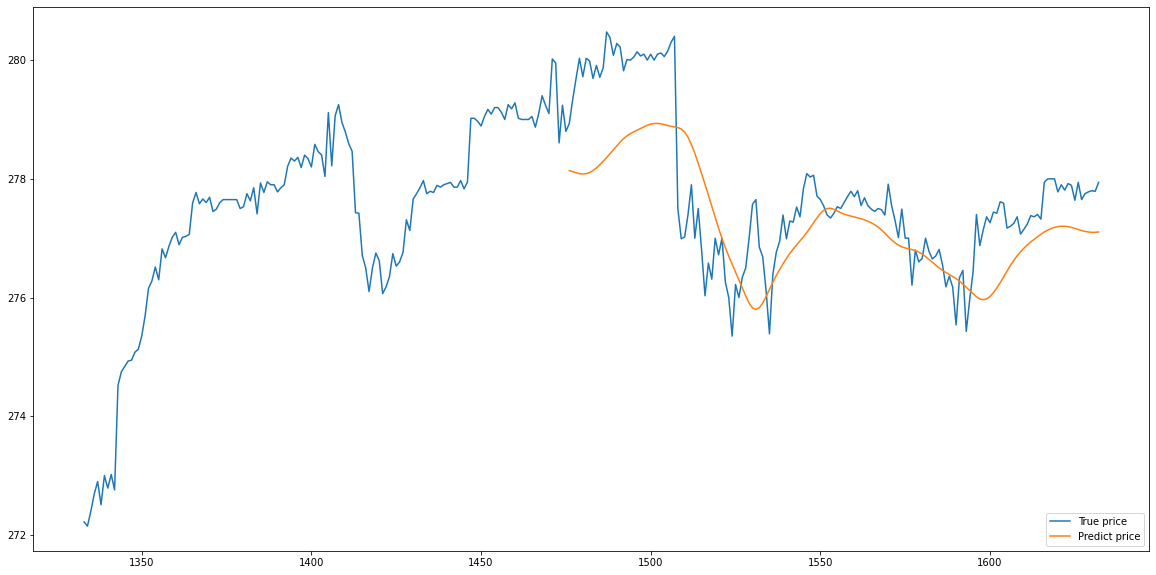

In [540]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/25
40/40 [==============================] - 17s 190ms/step - loss: 0.0593 - val_loss: 0.0257
Epoch 2/25
40/40 [==============================] - 5s 128ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 3/25
40/40 [==============================] - 5s 126ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 4/25
40/40 [==============================] - 5s 127ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 5/25
40/40 [==============================] - 5s 126ms/step - loss: 0.0029 - val_loss: 0.0056
Epoch 6/25
40/40 [==============================] - 5s 127ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 7/25
40/40 [==============================] - 5s 128ms/step - loss: 0.0027 - val_loss: 0.0056
Epoch 8/25
40/40 [==============================] - 5s 125ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/25
40/40 [==============================] - 6s 144ms/step - loss: 0.0025 - val_loss: 5.0723e-04
Epoch 10/25
40/40 [==============================] - 6s 141ms/step - loss: 0.0025 - val_loss: 0

<ipython-input-541-dba8dd37adbb>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


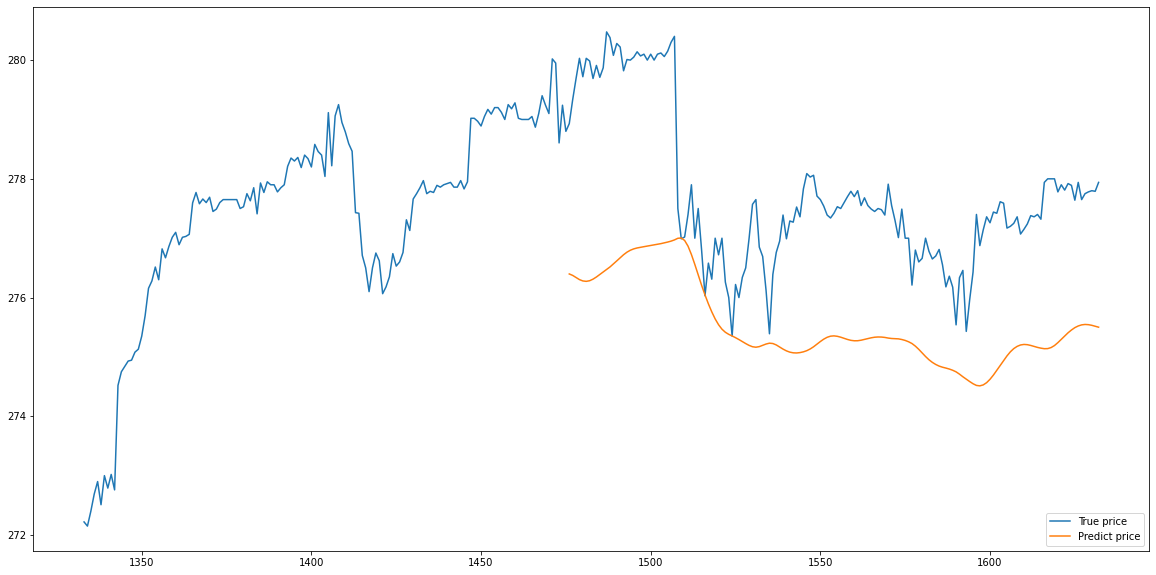

In [541]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/25
40/40 [==============================] - 12s 162ms/step - loss: 0.0670 - val_loss: 0.0130
Epoch 2/25
40/40 [==============================] - 5s 119ms/step - loss: 0.0043 - val_loss: 0.0059
Epoch 3/25
40/40 [==============================] - 5s 118ms/step - loss: 0.0036 - val_loss: 0.0095
Epoch 4/25
40/40 [==============================] - 5s 136ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 5/25
40/40 [==============================] - 5s 129ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 6/25
40/40 [==============================] - 6s 138ms/step - loss: 0.0028 - val_loss: 0.0070
Epoch 7/25
40/40 [==============================] - 6s 150ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 8/25
40/40 [==============================] - 5s 121ms/step - loss: 0.0027 - val_loss: 6.7240e-04
Epoch 9/25
40/40 [==============================] - 5s 119ms/step - loss: 0.0028 - val_loss: 0.0053
Epoch 10/25
40/40 [==============================] - 5s 121ms/step - loss: 0.0022 - val_loss: 0

<ipython-input-448-e5815714d951>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


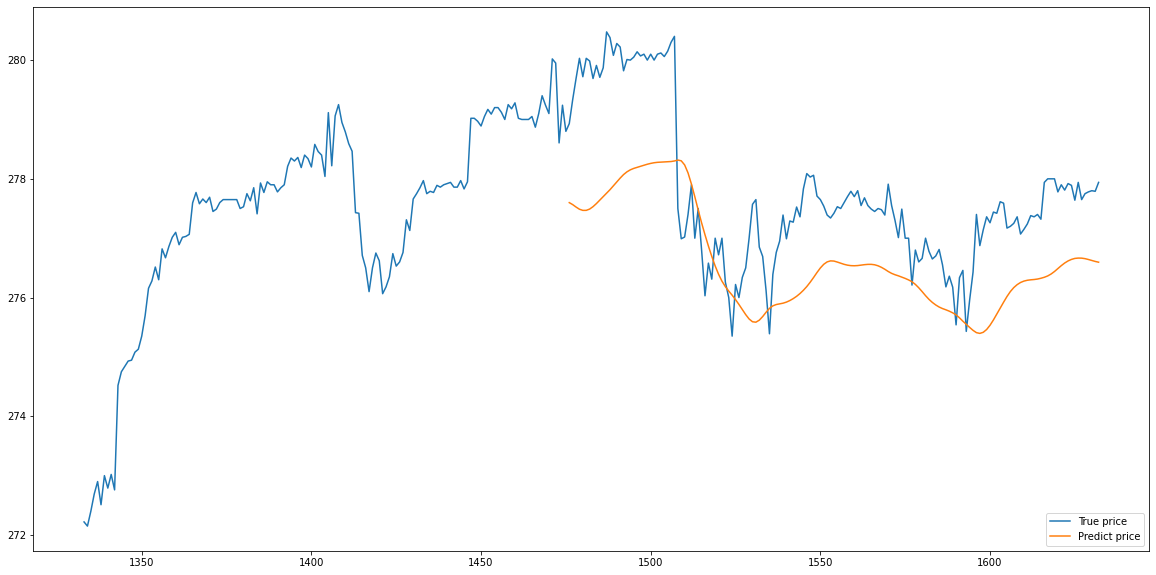

In [448]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/25
40/40 [==============================] - 14s 158ms/step - loss: 0.0567 - val_loss: 0.0355
Epoch 2/25
40/40 [==============================] - 5s 123ms/step - loss: 0.0048 - val_loss: 0.0134
Epoch 3/25
40/40 [==============================] - 5s 120ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 4/25
40/40 [==============================] - 5s 121ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 5/25
40/40 [==============================] - 5s 121ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 6/25
40/40 [==============================] - 5s 127ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/25
40/40 [==============================] - 5s 122ms/step - loss: 0.0025 - val_loss: 0.0217
Epoch 8/25
40/40 [==============================] - 5s 123ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 9/25
40/40 [==============================] - 5s 123ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 10/25
40/40 [==============================] - 5s 126ms/step - loss: 0.0023 - val_loss: 0.006

<ipython-input-542-0fd80c0db340>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


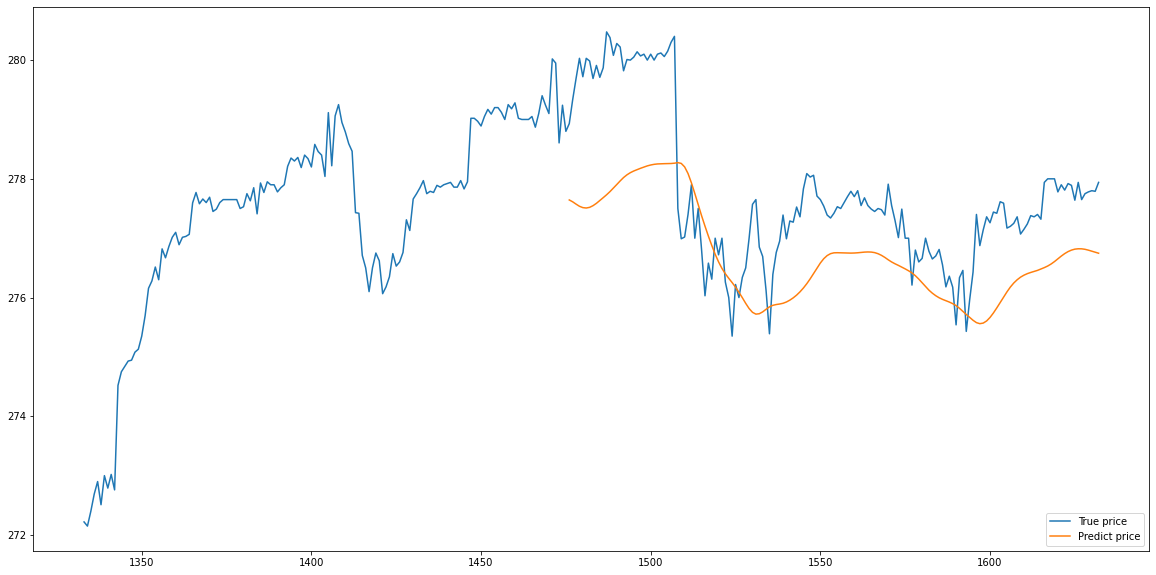

In [542]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

## 3. XGBOOST

### a. Prepare Input

In [524]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume']]
dataset

close     volume
0     248.88   815307.0
1     248.64  1142659.0
2     248.69   822538.0
3     247.95   850538.0
4     248.12  1663982.0
...      ...        ...
1628  277.75     1611.0
1629  277.78      220.0
1630  277.80     1053.0
1631  277.79     1233.0
1632  277.94     1600.0

[1633 rows x 2 columns]

In [525]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
dataset

<ipython-input-525-59d23a3ddc10>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-525-59d23a3ddc10>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)


close     volume  close_date_1  volume_date_1  close_date_2  \
0     248.88   815307.0           NaN            NaN           NaN   
1     248.64  1142659.0        248.88       815307.0           NaN   
2     248.69   822538.0        248.64      1142659.0        248.88   
3     247.95   850538.0        248.69       822538.0        248.64   
4     248.12  1663982.0        247.95       850538.0        248.69   
...      ...        ...           ...            ...           ...   
1628  277.75     1611.0        277.65         4209.0        277.94   
1629  277.78      220.0        277.75         1611.0        277.65   
1630  277.80     1053.0        277.78          220.0        277.75   
1631  277.79     1233.0        277.80         1053.0        277.78   
1632  277.94     1600.0        277.79         1233.0        277.80   

      volume_date_2  
0               NaN  
1               NaN  
2          815307.0  
3         1142659.0  
4          822538.0  
...             ...  
1628          200.0  
1629         4209.0  
1630         1611.0  
1631          220.0  
1632         1053.0  

[1633 rows x 6 columns]

In [526]:
dataset.dropna(inplace=True)
dataset

<ipython-input-526-0277f825f9c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(inplace=True)


close     volume  close_date_1  volume_date_1  close_date_2  \
2     248.69   822538.0        248.64      1142659.0        248.88   
3     247.95   850538.0        248.69       822538.0        248.64   
4     248.12  1663982.0        247.95       850538.0        248.69   
5     248.51  1965033.0        248.12      1663982.0        247.95   
6     248.31   516271.0        248.51      1965033.0        248.12   
...      ...        ...           ...            ...           ...   
1628  277.75     1611.0        277.65         4209.0        277.94   
1629  277.78      220.0        277.75         1611.0        277.65   
1630  277.80     1053.0        277.78          220.0        277.75   
1631  277.79     1233.0        277.80         1053.0        277.78   
1632  277.94     1600.0        277.79         1233.0        277.80   

      volume_date_2  
2          815307.0  
3         1142659.0  
4          822538.0  
5          850538.0  
6         1663982.0  
...             ...  
1628          200.0  
1629         4209.0  
1630         1611.0  
1631          220.0  
1632         1053.0  

[1631 rows x 6 columns]

In [527]:
X = dataset.drop(['close', 'volume'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1631, 4)
(1631, 1)


close_date_1  volume_date_1  close_date_2  volume_date_2
2           248.64      1142659.0        248.88       815307.0
3           248.69       822538.0        248.64      1142659.0
4           247.95       850538.0        248.69       822538.0
5           248.12      1663982.0        247.95       850538.0
6           248.51      1965033.0        248.12      1663982.0
...            ...            ...           ...            ...
1628        277.65         4209.0        277.94          200.0
1629        277.75         1611.0        277.65         4209.0
1630        277.78          220.0        277.75         1611.0
1631        277.80         1053.0        277.78          220.0
1632        277.79         1233.0        277.80         1053.0

[1631 rows x 4 columns]

In [528]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1468, 4)
Size test:  (163, 4)


### b. Train Model

In [471]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST.dat", "wb"))

### c. Test Model

In [529]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST.dat", "rb"))

In [530]:
predictions = model_xgboost.predict(X_test)
predictions

array([278.52924, 278.47015, 278.4858 , 278.43542, 278.32352, 278.46002,
       278.44095, 278.4355 , 278.4353 , 278.43393, 278.46005, 278.4347 ,
       278.4353 , 278.4645 , 278.5144 , 278.48428, 278.5144 , 278.5144 ,
       278.4584 , 278.473  , 278.4353 , 278.48428, 278.48428, 278.4645 ,
       278.40857, 278.39236, 278.45166, 278.49805, 278.59262, 278.60342,
       278.56732, 278.56732, 278.56732, 278.56732, 278.60342, 278.60342,
       278.56732, 278.58487, 278.60577, 277.8386 , 277.17413, 277.22992,
       277.49124, 278.03995, 277.33878, 277.63266, 277.0426 , 276.43372,
       276.7885 , 276.6492 , 277.266  , 276.99094, 277.23428, 276.6384 ,
       276.402  , 275.85132, 276.6384 , 276.402  , 276.6384 , 276.7438 ,
       277.23428, 277.59863, 277.68704, 277.07306, 276.71896, 276.2343 ,
       275.67816, 276.6379 , 276.99515, 277.00568, 277.20596, 277.04532,
       277.20242, 277.20688, 277.51788, 277.2506 , 277.83084, 278.02072,
       278.1475 , 278.1974 , 277.6556 , 277.55942, 

In [531]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-531-88868e85d37d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


close     volume  close_date_1  volume_date_1  close_date_2  \
1470  279.100  1229749.0       279.240      2016357.0        279.40   
1471  280.020  1491561.0       279.100      1229749.0        279.24   
1472  279.950  1279550.0       280.020      1491561.0        279.10   
1473  278.605  1242721.0       279.950      1279550.0        280.02   
1474  279.240  1037979.0       278.605      1242721.0        279.95   
...       ...        ...           ...            ...           ...   
1628  277.750     1611.0       277.650         4209.0        277.94   
1629  277.780      220.0       277.750         1611.0        277.65   
1630  277.800     1053.0       277.780          220.0        277.75   
1631  277.790     1233.0       277.800         1053.0        277.78   
1632  277.940     1600.0       277.790         1233.0        277.80   

      volume_date_2  predictions  
1470        39330.0   278.529236  
1471      2016357.0   278.470154  
1472      1229749.0   278.485809  
1473      1491561.0   278.435425  
1474      1279550.0   278.323517  
...             ...          ...  
1628          200.0   277.741669  
1629         4209.0   277.886139  
1630         1611.0   277.901398  
1631          220.0   277.857117  
1632         1053.0   277.886139  

[163 rows x 7 columns]

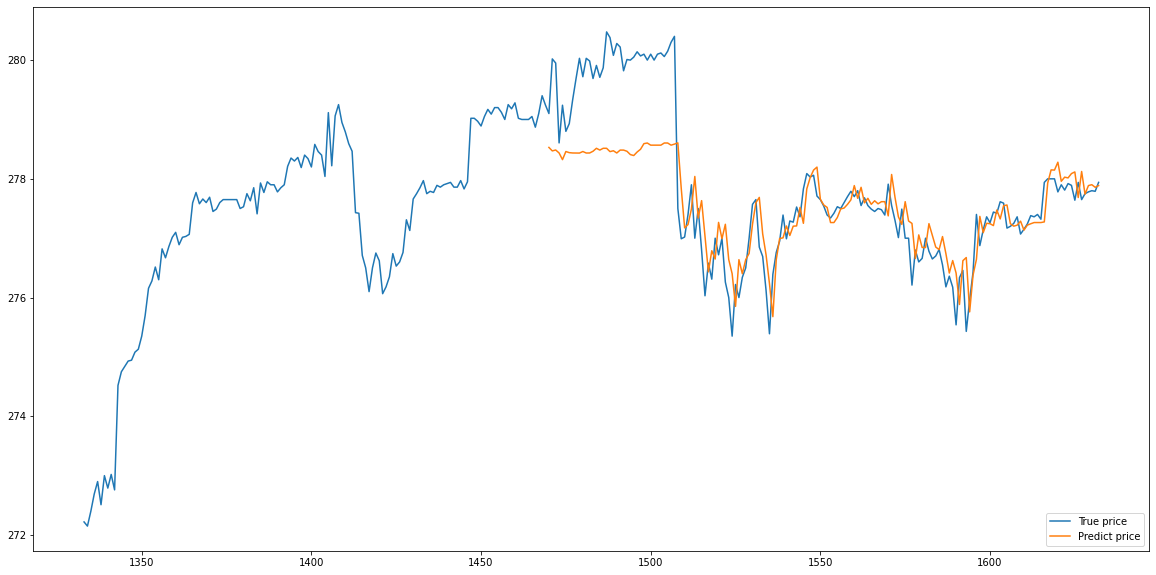

In [532]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [577]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC']]
dataset

close     volume     ROC
0     248.88   815307.0 -0.9117
1     248.64  1142659.0 -0.8731
2     248.69   822538.0 -0.9164
3     247.95   850538.0 -1.3527
4     248.12  1663982.0 -1.2615
...      ...        ...     ...
1628  277.75     1611.0  0.1406
1629  277.78      220.0  0.2563
1630  277.80     1053.0  0.2345
1631  277.79     1233.0  0.1984
1632  277.94     1600.0  0.2019

[1633 rows x 3 columns]

In [578]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
dataset

<ipython-input-578-6cf4d7473392>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-578-6cf4d7473392>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-578-6cf4d7473392>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

close     volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
0     248.88   815307.0 -0.9117           NaN            NaN         NaN   
1     248.64  1142659.0 -0.8731        248.88       815307.0     -0.9117   
2     248.69   822538.0 -0.9164        248.64      1142659.0     -0.8731   
3     247.95   850538.0 -1.3527        248.69       822538.0     -0.9164   
4     248.12  1663982.0 -1.2615        247.95       850538.0     -1.3527   
...      ...        ...     ...           ...            ...         ...   
1628  277.75     1611.0  0.1406        277.65         4209.0      0.1443   
1629  277.78      220.0  0.2563        277.75         1611.0      0.1406   
1630  277.80     1053.0  0.2345        277.78          220.0      0.2563   
1631  277.79     1233.0  0.1984        277.80         1053.0      0.2345   
1632  277.94     1600.0  0.2019        277.79         1233.0      0.1984   

      close_date_2  volume_date_2  ROC_date_2  
0              NaN            NaN         NaN  
1              NaN            NaN         NaN  
2           248.88       815307.0     -0.9117  
3           248.64      1142659.0     -0.8731  
4           248.69       822538.0     -0.9164  
...            ...            ...         ...  
1628        277.94          200.0      0.2670  
1629        277.65         4209.0      0.1443  
1630        277.75         1611.0      0.1406  
1631        277.78          220.0      0.2563  
1632        277.80         1053.0      0.2345  

[1633 rows x 9 columns]

In [554]:
dataset.dropna(inplace=True)
dataset

<ipython-input-554-0277f825f9c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(inplace=True)


close     volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
2     248.69   822538.0 -0.9164        248.64      1142659.0     -0.8731   
3     247.95   850538.0 -1.3527        248.69       822538.0     -0.9164   
4     248.12  1663982.0 -1.2615        247.95       850538.0     -1.3527   
5     248.51  1965033.0 -0.9920        248.12      1663982.0     -1.2615   
6     248.31   516271.0 -0.9336        248.51      1965033.0     -0.9920   
...      ...        ...     ...           ...            ...         ...   
1628  277.75     1611.0  0.1406        277.65         4209.0      0.1443   
1629  277.78      220.0  0.2563        277.75         1611.0      0.1406   
1630  277.80     1053.0  0.2345        277.78          220.0      0.2563   
1631  277.79     1233.0  0.1984        277.80         1053.0      0.2345   
1632  277.94     1600.0  0.2019        277.79         1233.0      0.1984   

      close_date_2  volume_date_2  ROC_date_2  
2           248.88       815307.0     -0.9117  
3           248.64      1142659.0     -0.8731  
4           248.69       822538.0     -0.9164  
5           247.95       850538.0     -1.3527  
6           248.12      1663982.0     -1.2615  
...            ...            ...         ...  
1628        277.94          200.0      0.2670  
1629        277.65         4209.0      0.1443  
1630        277.75         1611.0      0.1406  
1631        277.78          220.0      0.2563  
1632        277.80         1053.0      0.2345  

[1631 rows x 9 columns]

In [555]:
X = dataset.drop(['close', 'volume', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1631, 6)
(1631, 1)


close_date_1  volume_date_1  ROC_date_1  close_date_2  volume_date_2  \
2           248.64      1142659.0     -0.8731        248.88       815307.0   
3           248.69       822538.0     -0.9164        248.64      1142659.0   
4           247.95       850538.0     -1.3527        248.69       822538.0   
5           248.12      1663982.0     -1.2615        247.95       850538.0   
6           248.51      1965033.0     -0.9920        248.12      1663982.0   
...            ...            ...         ...           ...            ...   
1628        277.65         4209.0      0.1443        277.94          200.0   
1629        277.75         1611.0      0.1406        277.65         4209.0   
1630        277.78          220.0      0.2563        277.75         1611.0   
1631        277.80         1053.0      0.2345        277.78          220.0   
1632        277.79         1233.0      0.1984        277.80         1053.0   

      ROC_date_2  
2        -0.9117  
3        -0.8731  
4        -0.9164  
5        -1.3527  
6        -1.2615  
...          ...  
1628      0.2670  
1629      0.1443  
1630      0.1406  
1631      0.2563  
1632      0.2345  

[1631 rows x 6 columns]

In [556]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1468, 6)
Size test:  (163, 6)


In [557]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC.dat", "wb"))

In [558]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC.dat", "rb"))

In [559]:
predictions = model_xgboost.predict(X_test)
predictions

array([278.5188 , 278.48938, 278.50858, 278.56808, 278.45914, 278.43182,
       278.4617 , 278.4364 , 278.45117, 278.51068, 278.51068, 278.53613,
       278.44205, 278.52924, 278.54883, 278.4911 , 278.54883, 278.4911 ,
       278.5338 , 278.4675 , 278.4998 , 278.6042 , 278.54883, 278.5002 ,
       278.52536, 278.54773, 278.54443, 278.57877, 278.56003, 278.5296 ,
       278.5394 , 278.48767, 278.49814, 278.48767, 278.481  , 278.49146,
       278.48767, 278.51462, 278.4971 , 277.61847, 277.10745, 277.08267,
       277.34277, 277.82736, 277.214  , 277.50507, 276.95303, 276.4397 ,
       276.8394 , 276.6761 , 277.08267, 276.95303, 277.08267, 276.6761 ,
       276.4397 , 275.889  , 276.6761 , 276.4397 , 276.6761 , 276.83487,
       277.0959 , 277.66565, 277.68445, 277.06635, 276.88116, 276.43466,
       275.9009 , 276.8981 , 277.02097, 277.14282, 277.2412 , 277.08826,
       277.16992, 277.15033, 277.55017, 277.25125, 277.69455, 278.16324,
       278.25888, 278.2378 , 277.69882, 277.62204, 

In [560]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-560-88868e85d37d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


close     volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
1470  279.100  1229749.0  0.0753       279.240      2016357.0      0.0968   
1471  280.020  1491561.0  0.3476       279.100      1229749.0      0.0753   
1472  279.950  1279550.0  0.2794       280.020      1491561.0      0.3476   
1473  278.605  1242721.0 -0.1738       279.950      1279550.0      0.2794   
1474  279.240  1037979.0  0.0143       278.605      1242721.0     -0.1738   
...       ...        ...     ...           ...            ...         ...   
1628  277.750     1611.0  0.1406       277.650         4209.0      0.1443   
1629  277.780      220.0  0.2563       277.750         1611.0      0.1406   
1630  277.800     1053.0  0.2345       277.780          220.0      0.2563   
1631  277.790     1233.0  0.1984       277.800         1053.0      0.2345   
1632  277.940     1600.0  0.2019       277.790         1233.0      0.1984   

      close_date_2  volume_date_2  ROC_date_2  predictions  
1470        279.40        39330.0      0.1362   278.518799  
1471        279.24      2016357.0      0.0968   278.489380  
1472        279.10      1229749.0      0.0753   278.508575  
1473        280.02      1491561.0      0.3476   278.568085  
1474        279.95      1279550.0      0.2794   278.459137  
...            ...            ...         ...          ...  
1628        277.94          200.0      0.2670   277.712921  
1629        277.65         4209.0      0.1443   277.712097  
1630        277.75         1611.0      0.1406   277.781647  
1631        277.78          220.0      0.2563   277.770721  
1632        277.80         1053.0      0.2345   277.751221  

[163 rows x 10 columns]

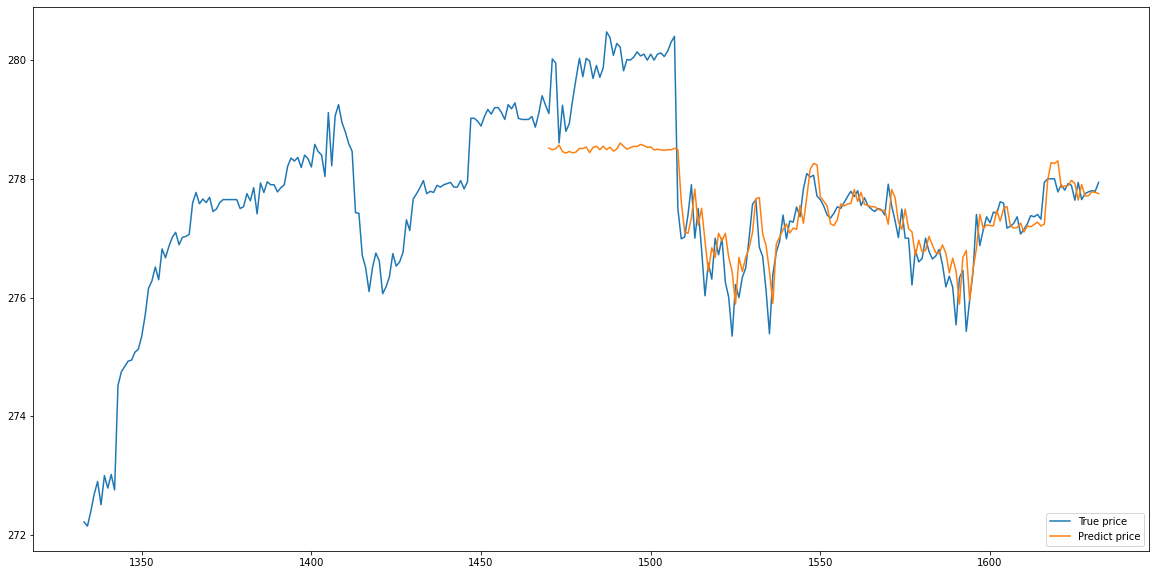

In [561]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

<ipython-input-562-9846d3c5b520>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-562-9846d3c5b520>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-562-9846d3c5b520>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

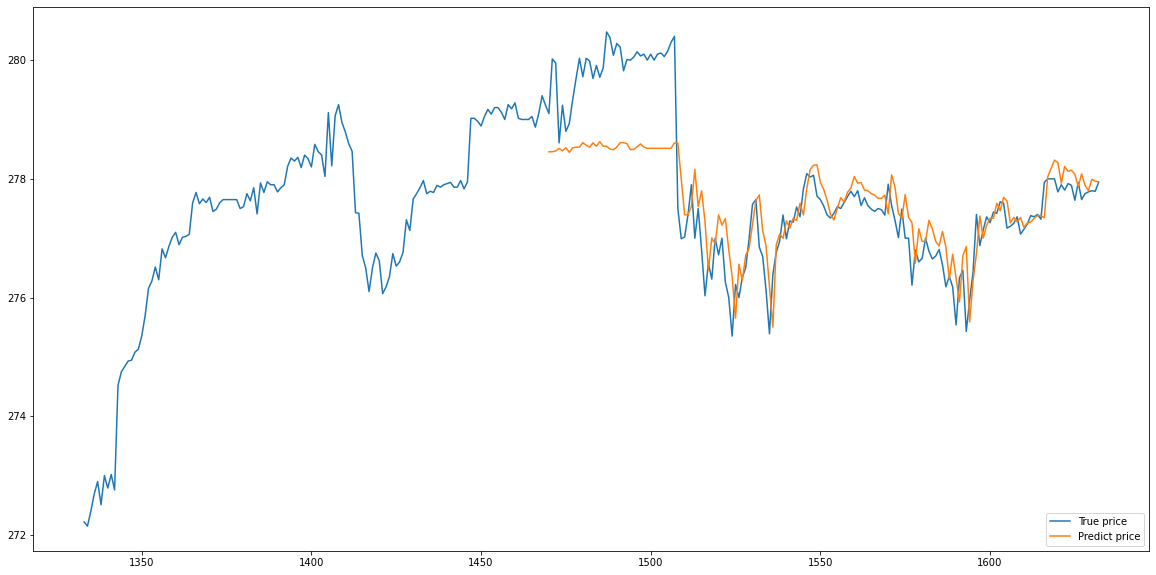

In [562]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

<ipython-input-563-3f6d725e48ed>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-563-3f6d725e48ed>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-563-3f6d725e48ed>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

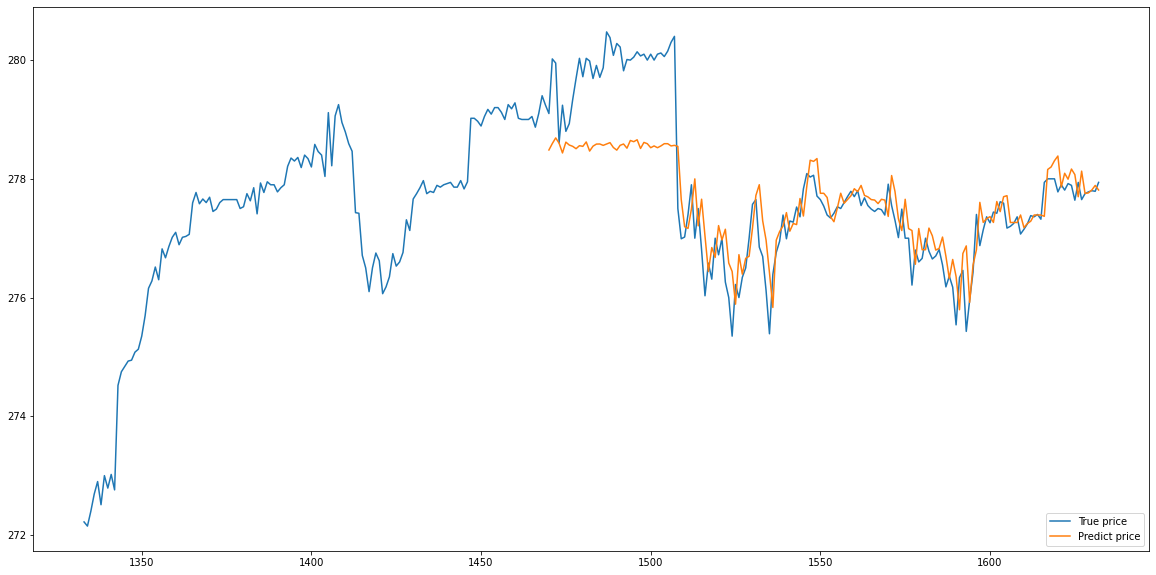

In [563]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

<ipython-input-564-48a5f70258f1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-564-48a5f70258f1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-564-48a5f70258f1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

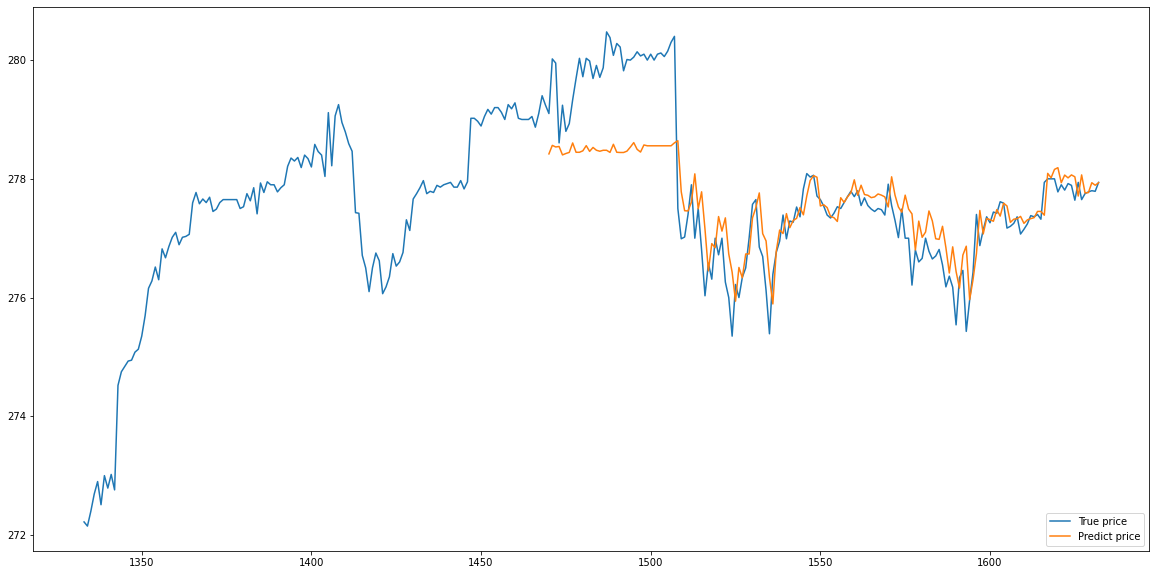

In [564]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)


dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

<ipython-input-565-5ea2a767d861>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-565-5ea2a767d861>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-565-5ea2a767d861>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

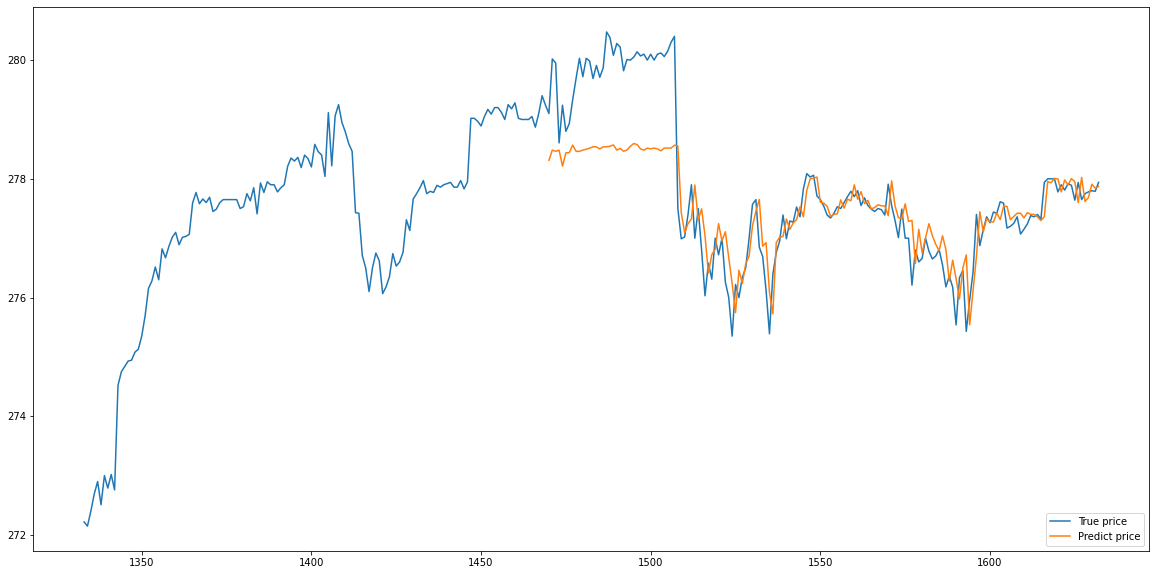

In [565]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

<ipython-input-566-219503b7df5f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-566-219503b7df5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-566-219503b7df5f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

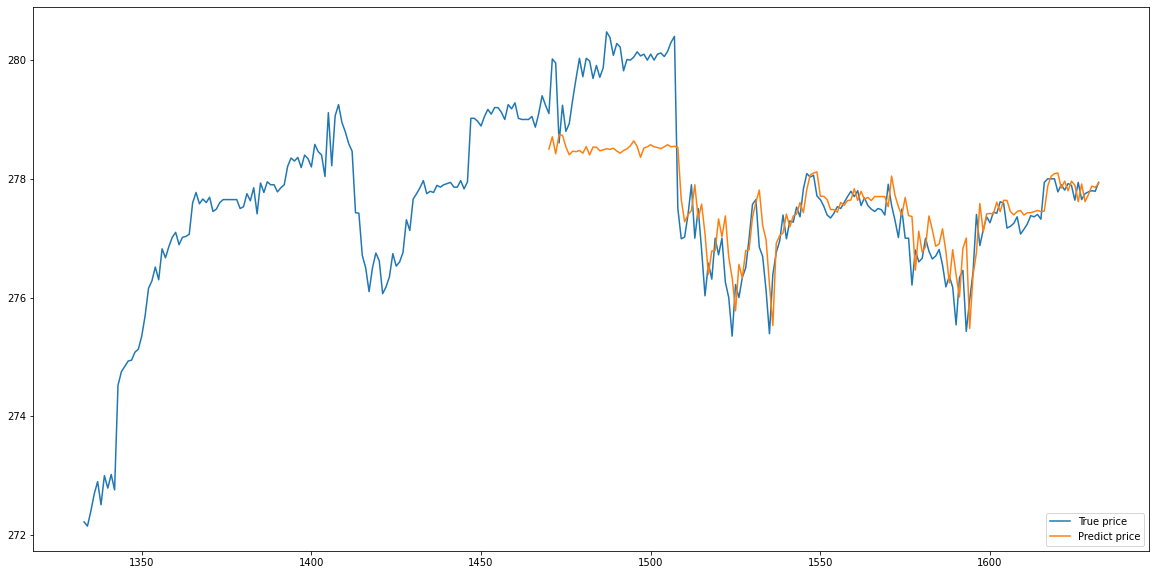

In [566]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

<ipython-input-567-5b40b009aecd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-567-5b40b009aecd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-567-5b40b009aecd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

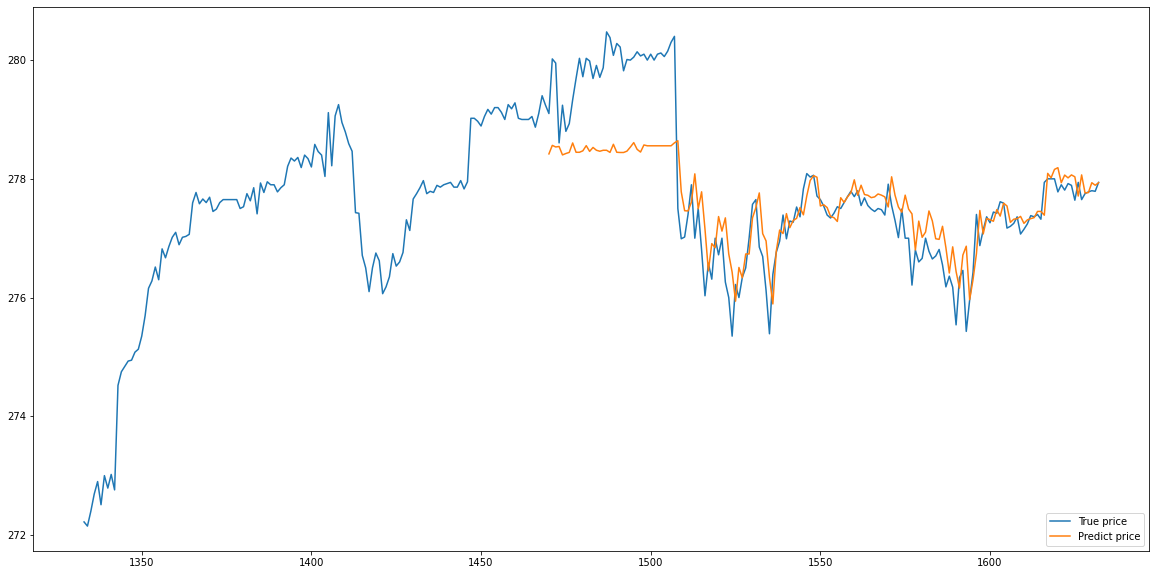

In [567]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

<ipython-input-568-314c8c89f95a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-568-314c8c89f95a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-568-314c8c89f95a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

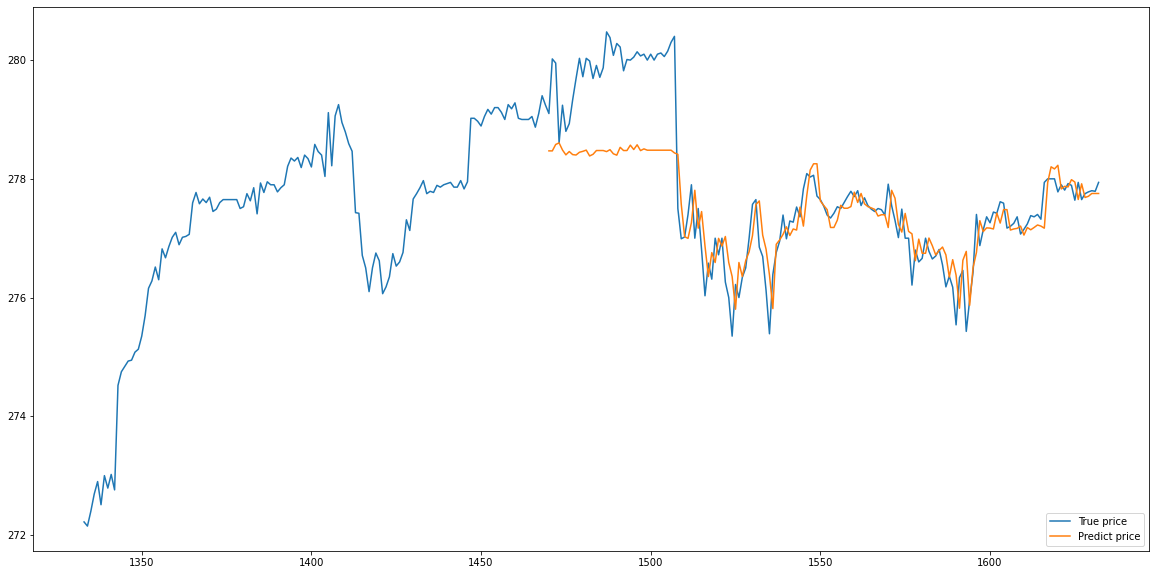

In [568]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

<ipython-input-569-c54dc5b09882>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-569-c54dc5b09882>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-569-c54dc5b09882>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

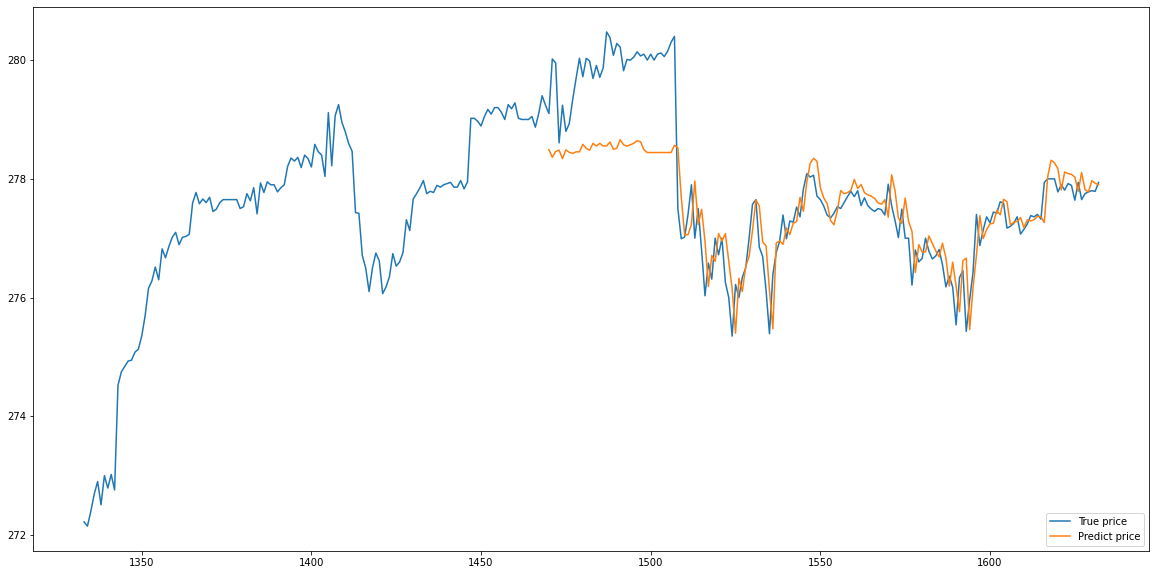

In [569]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

<ipython-input-570-da06544195d7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-570-da06544195d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-570-da06544195d7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

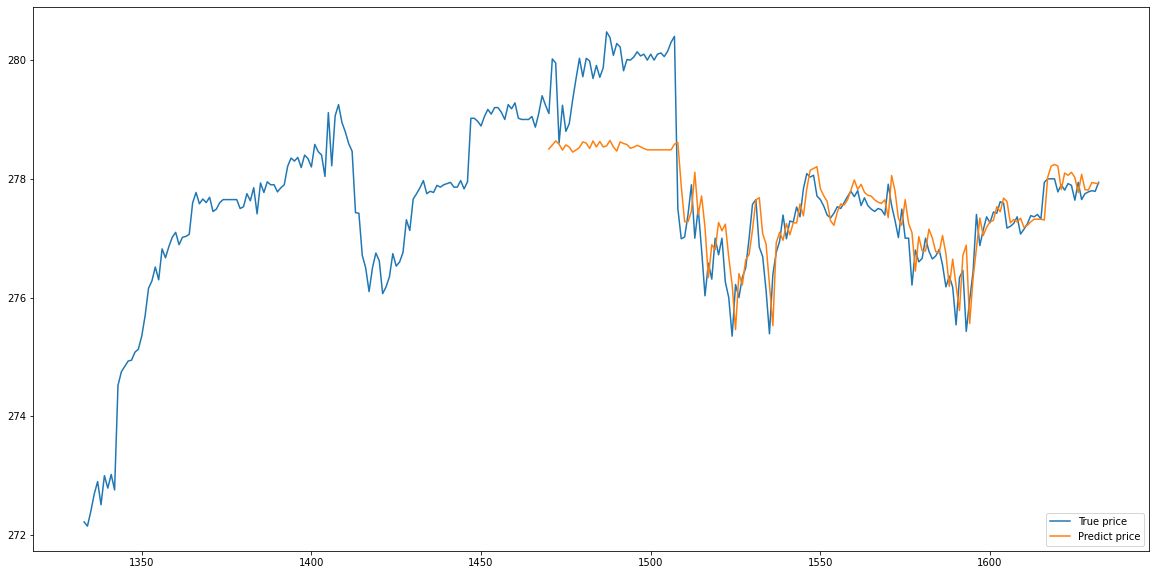

In [570]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

<ipython-input-571-b49420ee4260>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-571-b49420ee4260>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-571-b49420ee4260>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

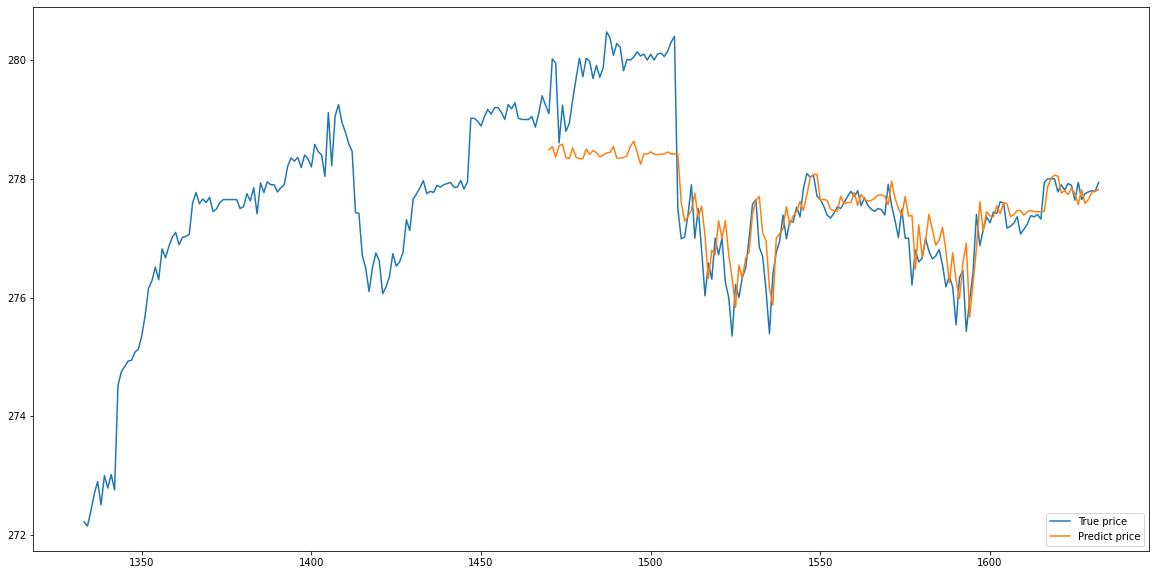

In [571]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

<ipython-input-572-b49420ee4260>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-572-b49420ee4260>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-572-b49420ee4260>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

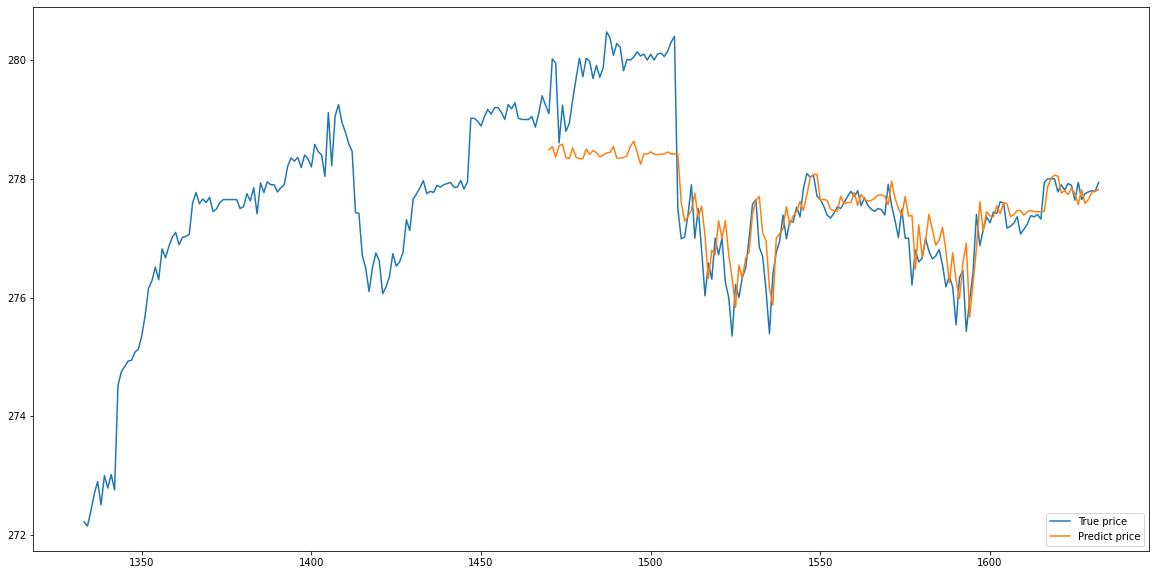

In [572]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

<ipython-input-573-5eb0c57214a1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-573-5eb0c57214a1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-573-5eb0c57214a1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

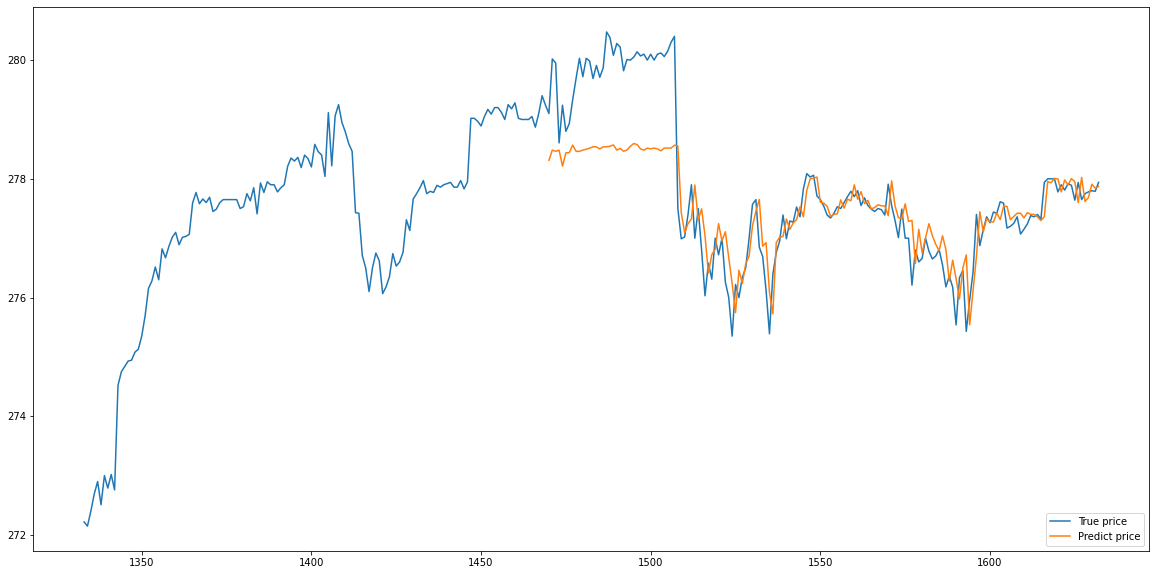

In [573]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

<ipython-input-574-2476e64968b4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-574-2476e64968b4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-574-2476e64968b4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

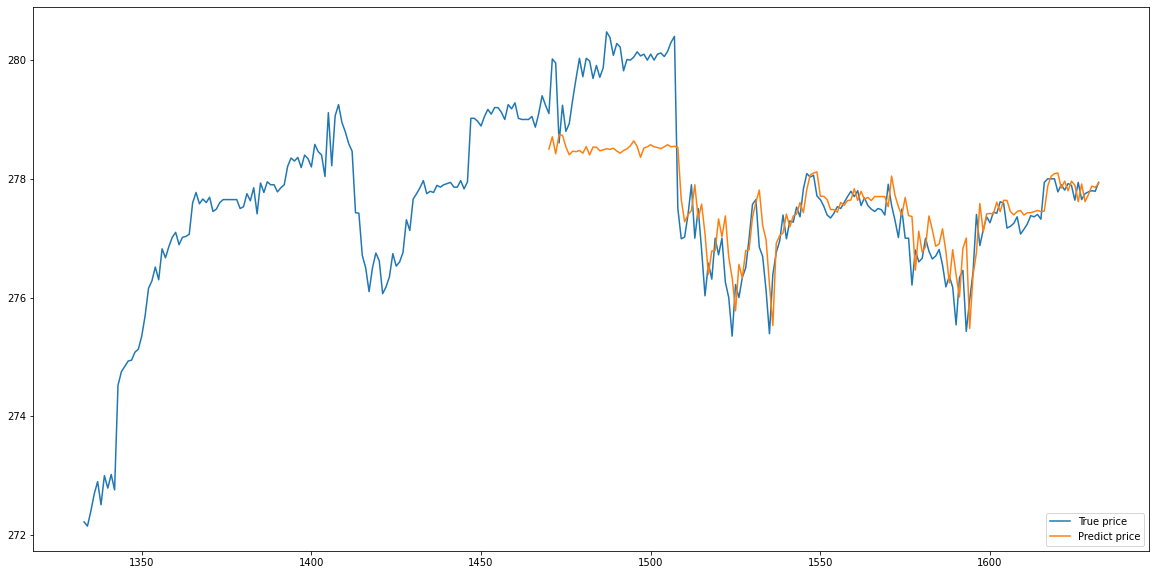

In [574]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

<ipython-input-575-bf6c0fd17b5a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-575-bf6c0fd17b5a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-575-bf6c0fd17b5a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

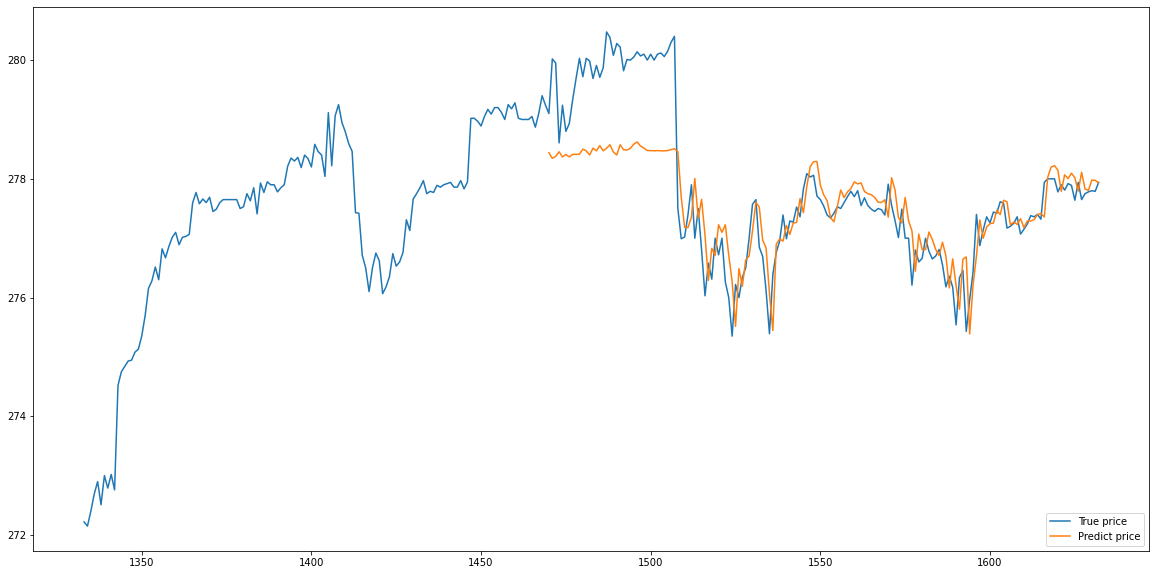

In [575]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

<ipython-input-576-054b3c6d96c4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-576-054b3c6d96c4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-576-054b3c6d96c4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

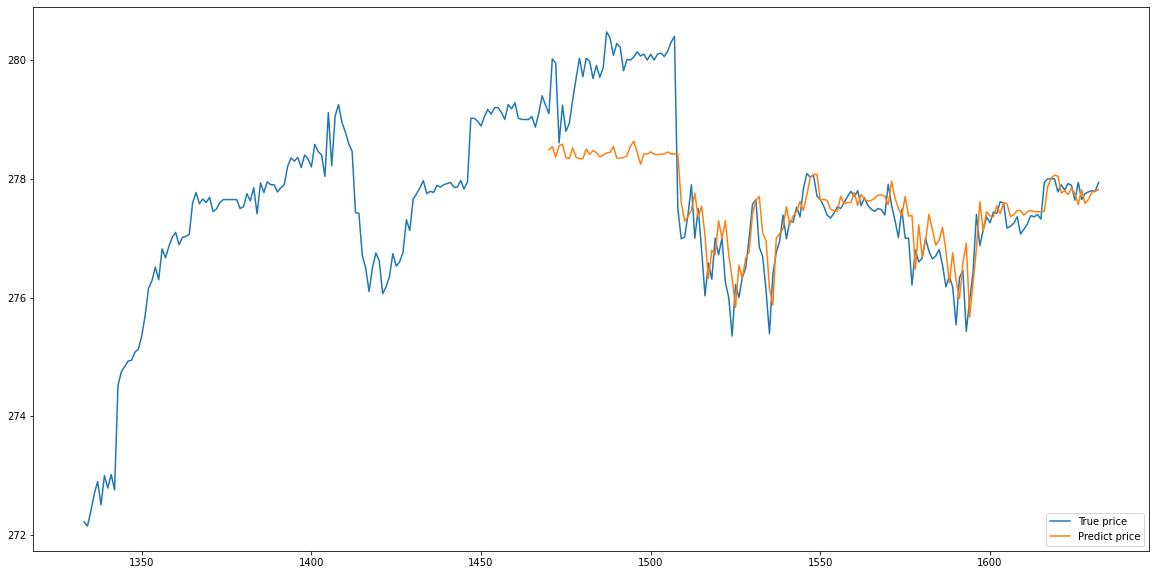

In [576]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### Predict Future

In [329]:
def xgboost_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.dat'
    model = pickle.load(open(modelFileName, "rb"))
    numDataPoint = int(period / 15)
    
    temp = indicatorArr.copy()
    temp.append('volume')
    data = data[temp]
    data = data[-5:]
    
    X = pd.DataFrame({})
    for column in data.columns:
        n = len(data)
        for i in range(1, n + 1):
            X[column + '_date_' + str(i)] = [data.iloc[n - i][column]] 
    
    predictedValue = model.predict(X)
    
    return predictedValue